In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
import matplotlib.cm as cm
import sys
import os
import errno
import netCDF4 as nc
import glob
import hickle as hkl

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
            
####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

a=6371.0e3
R=a

# c=5
# ncfile='/project2/tas1/pragallva/Summer_quarter_2019/exp_data/isca_repeat/HC0_la5m_oc5m/HC0_la5m_oc5m0.nc'
# v_var=nc.Dataset(ncfile,'r')
# sigma_full=v_var['pfull'][::-1]
# sigma_half=v_var['phalf'][::-1]
# lat_o=v_var['lat'][:]

In [2]:
ls /project2/tas1/pragallva/Fall_quarter_2018/post_process_data/synoptic/HC0_la50m_oc50m/

eddies_high_pass_freq_avg30.hkl  eddies_monthly_pass_freq_avg30.hkl
eddies_inter1_freq_avg30.hkl


In [3]:
def source(N=30, file='HC0_la5m_oc5m', FREQ='high', moment=1):
    momentum = '/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/synoptic/'\
               +file+'/eddies_'+FREQ+'_freq_avg'+str(N)+'.hkl'
    if moment == 1:
       return load(momentum)#, load(stress)

storm_pos=load('/project2/tas1/pragallva/Summer_quarter_2019/post_process_data/isca_repeat/data_in_pres_coord/avged_over30days/storm_pos.hkl')

m5m_5m_H        =  source(FREQ='high_pass', file='HC0_la5m_oc5m')
m5m_5m_M        =  source(FREQ='monthly_pass',  file='HC0_la5m_oc5m')
m5m_5m_I        =  source(FREQ='inter1', file='HC0_la5m_oc5m')
# m5m_5m_I2     =  source(FREQ='inter2', file='HC0_la5m_oc5m')

m50m_50m_H     =  source(FREQ='high_pass', file='HC0_la50m_oc50m')
m50m_50m_M    =  source(FREQ='monthly_pass',  file='HC0_la50m_oc50m')
m50m_50m_I     =  source(FREQ='inter1', file='HC0_la50m_oc50m')
# m50m_50m_I2     =  source(FREQ='inter2', file='HC0_la50m_oc50m')


In [4]:
pwd

u'/project2/tas1/pragallva/Summer_quarter_2019/codes/python_scripts/isca/jupyter_notebooks'

In [5]:
exp_H      = [m5m_5m_H, m50m_50m_H]
exp_I      = [m5m_5m_I, m50m_50m_I]
exp_M      = [m5m_5m_M, m50m_50m_M]
exp_names  = ['m5m_5m', 'm50m_50m']

lat = exp_H[0]['lat']
lon = exp_H[0]['lon']
sigma_full = exp_H[0]['sigma_full']

In [6]:
def extract_data( FREQ='H', verbose=False):
    if FREQ  == 'H':
        exps = exp_H
    if FREQ  == 'M':
        exps = exp_M
    if FREQ  == 'I':
        exps = exp_I
        
    days = '_'+FREQ    
    
    for key, value in exps[0].items():
      if type(value)==type({}):
             for sub_key, sub_value in value.items():
                globals()[sub_key+str(days)]=[]
                if verbose == True :
                     print sub_key+str(days)
      else :    
                globals()[key+str(days)]=[]
                if verbose == True :
                     print key+str(days)
                                    
                
                        
    for d in range(len(exps)):
        for key, value in exps[d].items():
            if type(value)==type({}):
                for sub_key, sub_value in value.items():
                    globals()[sub_key+str(days)].append(sub_value)
            else :    
                    globals()[key+str(days)].append(value)  
                                        
                    
                    
    for key, value in exps[0].items():
      if type(value)==type({}):
             for sub_key, sub_value in value.items():
                globals()[sub_key+str(days)]=np.array(globals()[sub_key+str(days)])
      else :    
                globals()[key+str(days)]=np.array(globals()[key+str(days)])


In [7]:
extract_data(FREQ='H', verbose=True)
extract_data(FREQ='M')
extract_data(FREQ='I')

vert_EKE_flux_H
EMF_H
vert_EKE_H
avg_days_H
vert_sensible_flux_H
EKE_H
vert_potential_flux_H
lon_H
latent_flux_H
vert_latent_flux_H
sigma_full_H
potential_flux_H
frequency_H
vert_EMF_H
lat_H
EKE_flux_H
sensible_flux_H


In [9]:
vert_EKE_H.shape

(2, 1741, 12)

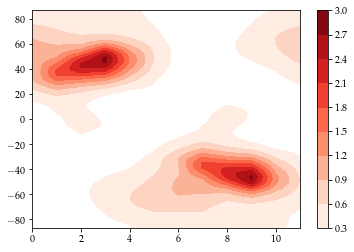

In [23]:
py.contourf(range(12),lat,vert_EKE_H[0,:,:]/10**6, np.arange(0.3,3.3,0.3), cmap=cm.Reds); 
py.colorbar();

## Fields to be NS averaged with flux_fag 1##

In [9]:
def N_S_avg(TE, flux_flag=-1):
    MONL = TE.shape[-1]
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))    
    avg = lambda x: (x[:,l_N,...]+flux_flag*np.roll(x[:,l_S,...][:,::-1,...], MONL/2, axis=-1))/2.0  
    TE1= avg(TE)
    ap= lambda x: np.append(x,x[...,0,None],axis=-1)
    return ap(TE1), lat[l_N]

from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  MONL = flux.shape[-1]  
  D = np.zeros(((flux.shape[0]),(flux.shape[-1])))
  for d in range(0,len(exp_H)):
    for m in range(0,MONL):
            l_range=((lat>=30) & (lat<=60)) 
            X=storm_pos
            interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
            try :
                D[d,m]=interpolation_function(X[d,m])
            except ValueError as err:
                D[d,m]==np.nan        
  return D

In [10]:
factorv = (2*np.pi*np.cos(np.deg2rad(lat))*R)[None,:,None]#/10**15
factor = (2*np.pi*np.cos(np.deg2rad(lat))*R)[None,:,None,None]#/10**15

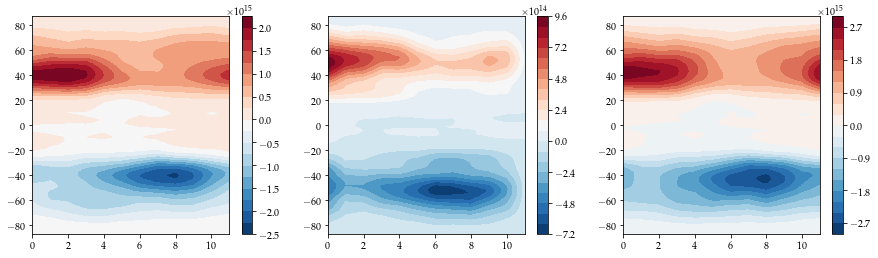

In [11]:
d=1; p=0
py.figure(figsize=(15,4))
py.subplot(1,3,1)
py.contourf(range(12),lat,(vert_sensible_flux_H*factorv)[d,:,:],20, cmap=cm.RdBu_r); py.colorbar()
py.subplot(1,3,2)
py.contourf(range(12),lat,(vert_sensible_flux_I*factorv)[d,:,:],20, cmap=cm.RdBu_r); py.colorbar()
py.subplot(1,3,3)
py.contourf(range(12),lat,(vert_sensible_flux_M*factorv)[d,:,:], 20,cmap=cm.RdBu_r); py.colorbar()

In [12]:
high=[sensible_flux_H, vert_sensible_flux_H,potential_flux_H,vert_potential_flux_H,latent_flux_H,vert_latent_flux_H ]
inter=[sensible_flux_I, vert_sensible_flux_I,potential_flux_I,vert_potential_flux_I,latent_flux_I,vert_latent_flux_I ]
monthly=[sensible_flux_M, vert_sensible_flux_M,potential_flux_M,vert_potential_flux_M,latent_flux_M,vert_latent_flux_M ]


EKE_Ha, lat_a = N_S_avg(EKE_H,1)
EKE_Ia, lat_a = N_S_avg(EKE_I,1)
vert_EKEa, lat_a = N_S_avg(vert_EKE_H,1)
vert_EKEIa, lat_a = N_S_avg(vert_EKE_M-vert_EKE_H,1)

from scipy.interpolate import interp1d

def find_zero(div):
  zero_loc = np.zeros((div.shape[0],13))
  for d in range(0,div.shape[0]):
      for m in range(0,13):
            l_range=((lat_a>=30) & (lat_a<=60))            
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

def spher_div(x,fac=1):
       N=100
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(x.shape[0]):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat_a[:])) ),N)
       return div

dtheta=np.radians(lat_a[1]-lat_a[0])
def eddies_avg(Y=high):
    TEsens_a                         =  N_S_avg(Y[0]*factor,-1)[0]
    TEsensv_a                        =  N_S_avg(Y[1]*factorv,-1)[0]
    TEpot_a                          =  N_S_avg(Y[2]*factor,-1)[0]
    TEpotv_a                         =  N_S_avg(Y[3]*factorv,-1)[0]
    TEmoist_a                        =  N_S_avg(Y[4]*factor,-1)[0]
    TEmoistv_a,lat_a                 =  N_S_avg(Y[5]*factorv,-1)
    TE_a =  (TEsensv_a+TEpotv_a+TEmoistv_a)/10**15
    TEv_a = (TEsens_a+TEpot_a+TEmoist_a)/10**15    
    div_TE_a=spher_div(TE_a*10**15)

    return TE_a, div_TE_a


TE_H, div_TE_H  = eddies_avg(Y=high)
TE_I, div_TE_I  = eddies_avg(Y=inter)
TE_M, div_TE_M  = eddies_avg(Y=monthly)
storm_pos_H = find_zero(div_TE_H)
storm_pos_I = find_zero(div_TE_I)
storm_pos_M = find_zero(div_TE_M)

TE_I = TE_M - TE_H
div_TE_I = div_TE_M- div_TE_H

from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  MONL = flux.shape[-1] 
  D = np.zeros(((flux.shape[0]),(flux.shape[-1])))
  for d in range(0,len(exp_H)):
    for m in range(0,MONL):
            l_range=((lat>=30) & (lat<=60)) 
            X=storm_pos
            interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
            try :
                D[d,m]=interpolation_function(X[d,m])
            except ValueError as err:
                D[d,m]==np.nan        
  return D

Ihigh  = inerp_at_max(flux=TE_H,lat=lat_a)
Iinter = inerp_at_max(flux=TE_I,lat=lat_a)
Itotal = inerp_at_max(flux=TE_I+TE_H,lat=lat_a)
Imonthly = inerp_at_max(flux=TE_M,lat=lat_a)
Ieke   = inerp_at_max(flux=vert_EKEa,lat=lat_a)

In [13]:
Ieke.shape

(2, 13)

In [14]:
def M(y):
    return y-y[:,:-1].mean(axis=-1)[:,None]

In [15]:
TE_MSE= np.load('/project2/tas1/pragallva/Summer_quarter_2019/codes/python_scripts/isca/jupyter_notebooks/TE_MSE_monthly.npy')
Intensity_monthly= \
np.load('/project2/tas1/pragallva/Summer_quarter_2019/codes/python_scripts/isca/jupyter_notebooks/Intensity_monthly.npy')

    

In [16]:
depths=[5,50]

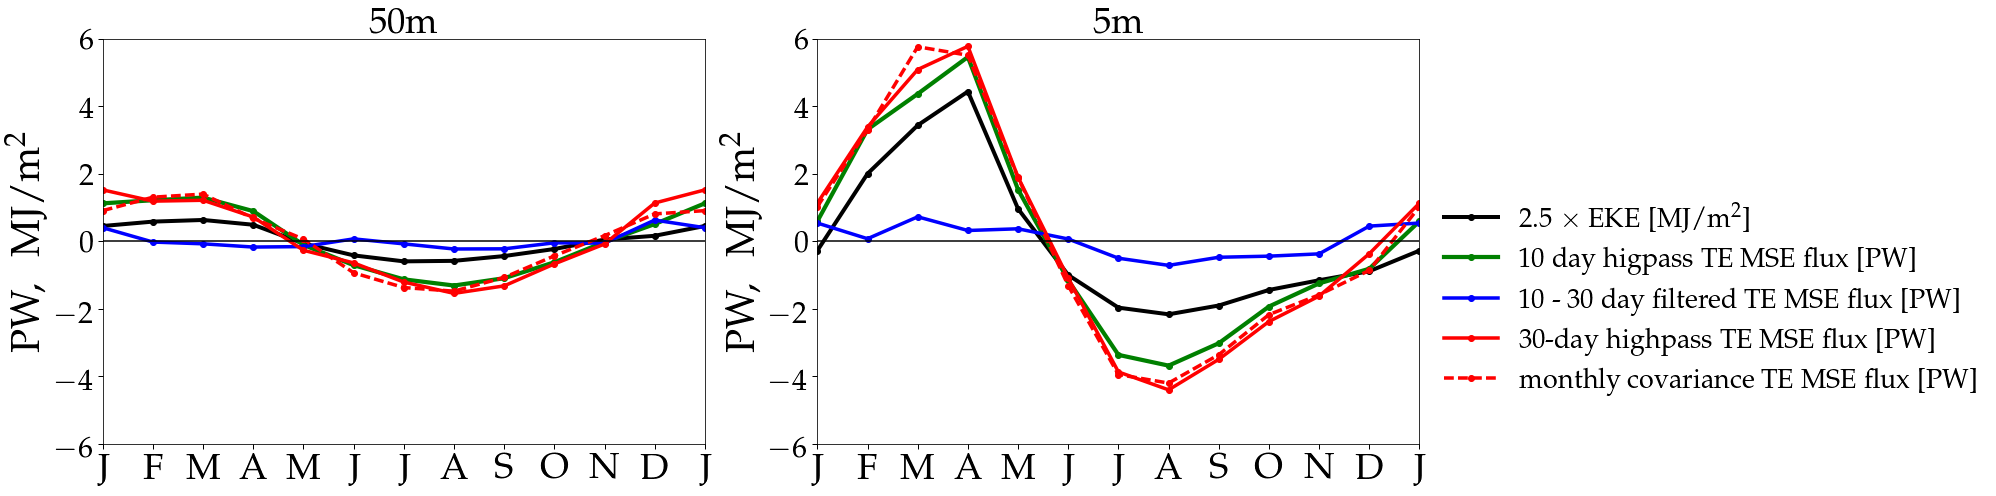

In [17]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')
mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']   

py.figure(figsize=(20,7))
i=0; l=6.2
for d in [1,0]:
    i=i+1
    py.subplot(1,2,i)
    py.plot(2.5*M(Ieke)[d,:]/10**6, 'ko-', label=r'2.5 $\times$ EKE [MJ/m$^2$]',lw=4.0)
    py.plot(M(Ihigh)[d,:],        'go-',  label=r'10 day higpass TE MSE flux [PW]',lw=4.2)
    py.plot(M(Iinter)[d,:],      'bo-',  label=r'10 - 30 day filtered TE MSE flux [PW]',lw=3.5)
    py.plot(M(Imonthly)[d,:],    'ro-',   label=r'30-day highpass TE MSE flux [PW]',lw=3.5)
    py.plot(M(Intensity_monthly)[d,:], 'ro--',   label=r'monthly covariance TE MSE flux [PW]',lw=3.5)
#     py.plot(M(Itotal)[d,:], 'yo-',   label=r'sum [PW]',lw=3.5)

    py.ylim(-6,6)
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel(r'PW,$\:\:$  MJ/m$^2$',fontsize=40)
    py.tick_params(labelsize=30,size=5,width=1)
    py.xticks(range(13), mticks,size=37)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    py.xlim(0,12)
    py.axhline(0,color='k')
    if d==0:
        py.legend(loc='best', fontsize=27,frameon=False, bbox_to_anchor=(1, 0.65),)
    py.title(str(depths[d])+'m',fontsize=37)
    py.tight_layout()
source= "/project2/tas1/pragallva/Winter_quarter_2019/codes/python_scripts/miscellaneous/Paper_figures_ISCA/Sep16/"
# py.savefig('Sep16_Figures/EKE_monTE_highTE.pdf',bbox_inches='tight')

In [18]:
# d=0
# py.plot(5*M(Ieke)[d,:]/10**6, 'ko-')
# py.plot(M(Ihigh)[d,:],      'ro--')
# py.plot(M(Intensity_monthly)[d,:],      'ro-')
# py.axhline(0)

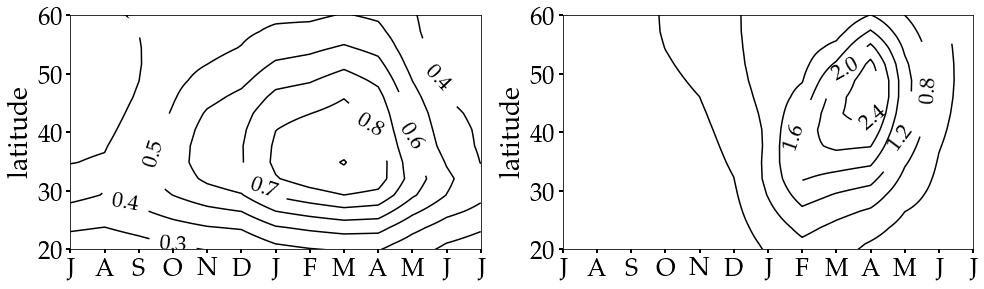

In [24]:
mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),6)
mticks2 = (np.array(['J','A','S','O','N','D', 'J','F','M','A','M','J','J']))

depths=['5m', '50m']

def roll(x):
    y=np.roll(x[...,:-1],6,axis=-1)
    return np.append(y, y[...,0,None],axis=-1)
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.figure(figsize=(25,25))
NN = 8
# loc=loc-1

d=1
py.subplot(5,3,1)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(vert_EKEa[d,:,:]/10**6),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
#py.title('10 day high pass filtered MSE flux (PW),  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

d=0
loc=22
n=0;
py.subplot(5,3,2)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(vert_EKEa[d,:,:]/10**6),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
#py.title(r'10 day high pass filtered MSE flux (PW), '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

py.savefig('Sep16_Figures/10_day_highpass_filtered_EKE.pdf')

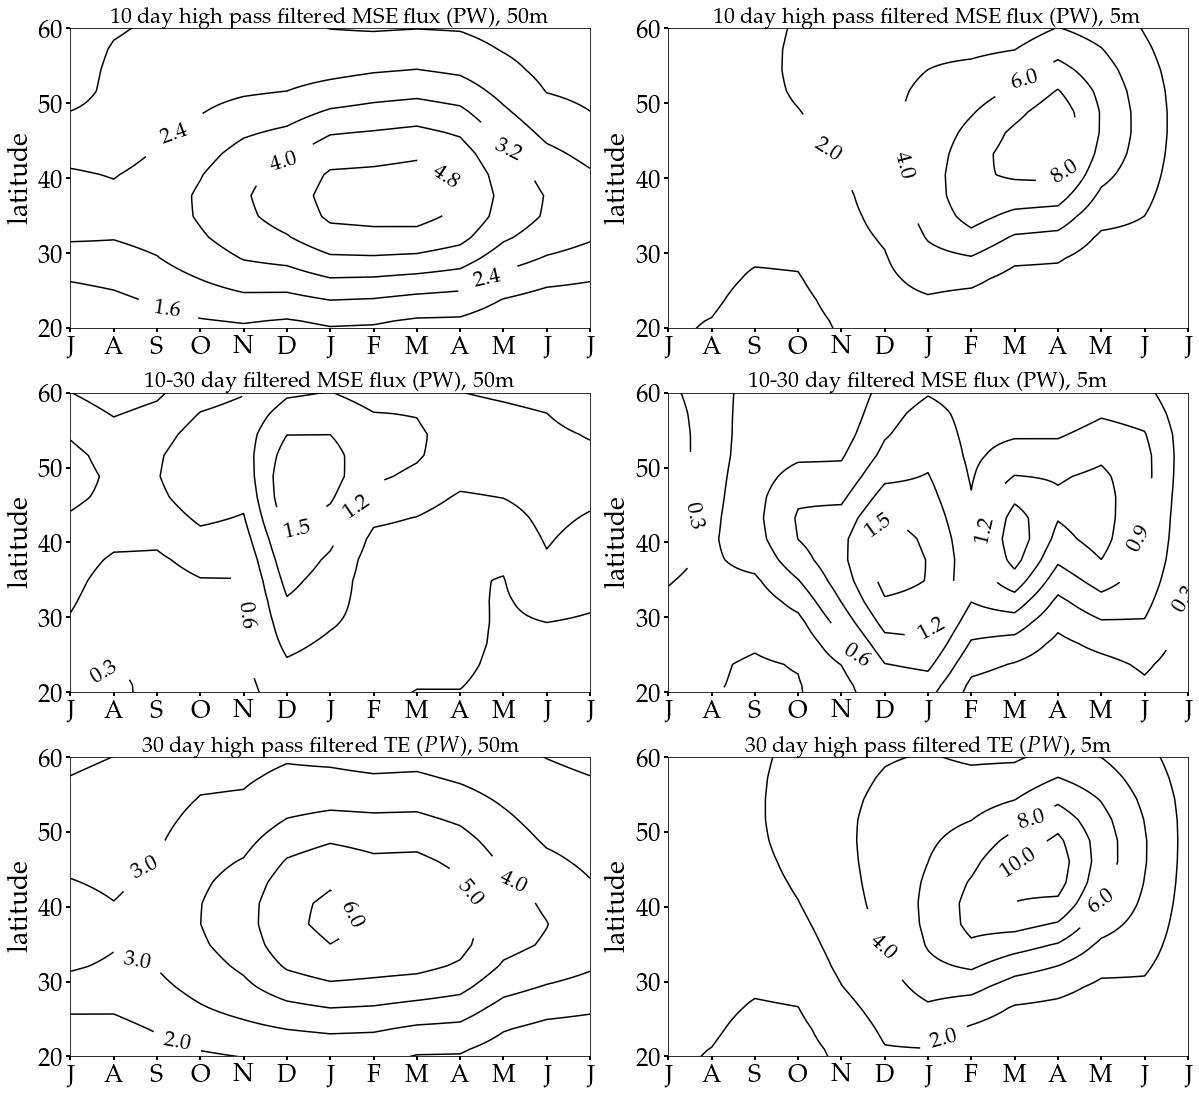

In [54]:
mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),6)
mticks2 = (np.array(['J','A','S','O','N','D', 'J','F','M','A','M','J','J']))

depths=['5m', '50m']

def roll(x):
    y=np.roll(x[...,:-1],6,axis=-1)
    return np.append(y, y[...,0,None],axis=-1)
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.figure(figsize=(25,25))
NN = 6
# loc=loc-1

d=1
py.subplot(5,3,1)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(TE_H[d,:,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title('10 day high pass filtered MSE flux (PW),  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

d=0
loc=22
n=0;
py.subplot(5,3,2)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(TE_H[d,:,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10 day high pass filtered MSE flux (PW), '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

d=1
py.subplot(5,3,4)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll((TE_I)[d,:,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title('10-30 day filtered MSE flux (PW),  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

d=0
loc=22
n=0;
py.subplot(5,3,5)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll((TE_I)[d,:,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10-30 day filtered MSE flux (PW), '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
py.tight_layout()


d=1
py.subplot(5,3,7)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll((TE_I+TE_H)[d,:,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'30 day high pass filtered TE ($PW$),  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

d=0
loc=22
n=0;
py.subplot(5,3,8)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll((TE_I+TE_H)[d,:,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'30 day high pass filtered TE ($PW$), '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
py.tight_layout()

#py.savefig('Sep16_Figures/high_filtered_TE.pdf')

In [19]:
# mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),6)
# mticks2 = (np.array(['J','A','S','O','N','D', 'J','F','M','A','M','J','J']))

# depths=['5m', '50m']
# CMAP = cm.spectral

# def roll(x):
#     y=np.roll(x[...,:-1],6,axis=-1)
#     return np.append(y, y[...,0,None],axis=-1)
# py.rc('text', usetex=True)
# py.rc('font', family='serif', serif='Palatino',weight='bold')

# py.figure(figsize=(25,25))
# NN = np.arange(0,8,0.5)
# # loc=loc-1

# d=1
# py.subplot(5,3,1)
# # py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
# c=py.contourf(range(13), lat_a, roll(TE_H[d,:,:]),NN, cmap=(CMAP)); #py.colorbar()
# #py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
# py.xticks(range(13), (mticks2),fontsize=15)
# py.ylim(20,60)
# py.xticks(range(13), (mticks2),fontsize=15)
# py.tick_params(labelsize=25,size=4,width=2)
# py.title('2-10 day filtered MSE flux (PW),  '+str(depths[d]),fontsize=22)
# py.ylabel('latitude',fontsize=27)
# # py.savefig('Sep8_Figures/high_filtered_TE.pdf')

# d=0
# loc=22
# n=0;
# py.subplot(5,3,2)
# # py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
# c=py.contourf(range(13), lat_a, roll(TE_H[d,:,:]),NN,cmap=CMAP); 
# #py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
# py.xticks(range(13), (mticks2),fontsize=15)
# py.ylim(20,60)
# py.xticks(range(13), (mticks2),fontsize=15)
# py.tick_params(labelsize=25,size=4,width=2)
# py.title(r'2-10 day filtered MSE flux (PW), '+str(depths[d]),fontsize=22)
# py.ylabel('latitude',fontsize=27)

# d=1
# py.subplot(5,3,4)
# # py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
# c=py.contourf(range(13), lat_a, roll(TE_I[d,:,:]),NN, cmap=CMAP); #py.colorbar()
# #py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
# py.xticks(range(13), (mticks2),fontsize=15)
# py.ylim(20,60)
# py.xticks(range(13), (mticks2),fontsize=15)
# py.tick_params(labelsize=25,size=4,width=2)
# py.title('10-30 day filtered MSE flux (PW),  '+str(depths[d]),fontsize=22)
# py.ylabel('latitude',fontsize=27)
# # py.savefig('Sep8_Figures/high_filtered_TE.pdf')

# d=0
# loc=22
# n=0;
# py.subplot(5,3,5)
# # py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
# c=py.contourf(range(13), lat_a, roll(TE_I[d,:,:]),NN,cmap=CMAP); 
# #py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
# py.xticks(range(13), (mticks2),fontsize=15)
# py.ylim(20,60)
# py.xticks(range(13), (mticks2),fontsize=15)
# py.tick_params(labelsize=25,size=4,width=2)
# py.title(r'10-30 day filtered MSE flux (PW), '+str(depths[d]),fontsize=22)
# py.ylabel('latitude',fontsize=27)
# py.tight_layout()



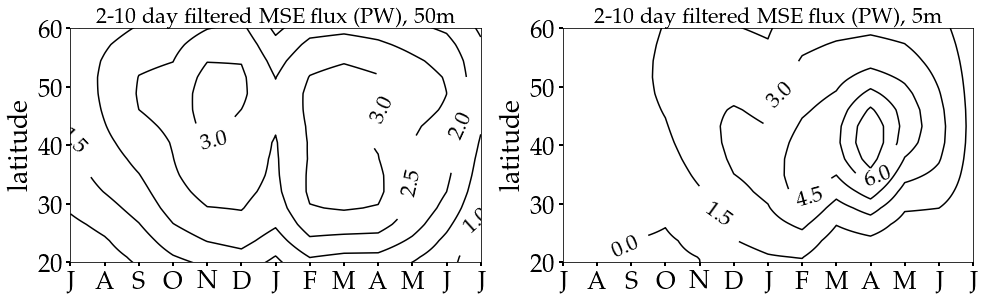

In [20]:
sumi  = TE_H + TE_I
mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),6)
mticks2 = (np.array(['J','A','S','O','N','D', 'J','F','M','A','M','J','J']))

depths=['5m', '50m']

def roll(x):
    y=np.roll(x[...,:-1],6,axis=-1)
    return np.append(y, y[...,0,None],axis=-1)
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.figure(figsize=(25,25))
NN = 6
# loc=loc-1
d=0
loc=22
n=0;
py.subplot(5,3,2)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(sumi[d,:,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'2-10 day filtered MSE flux (PW), '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

d=1
py.subplot(5,3,1)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(sumi[d,:,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title('2-10 day filtered MSE flux (PW),  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

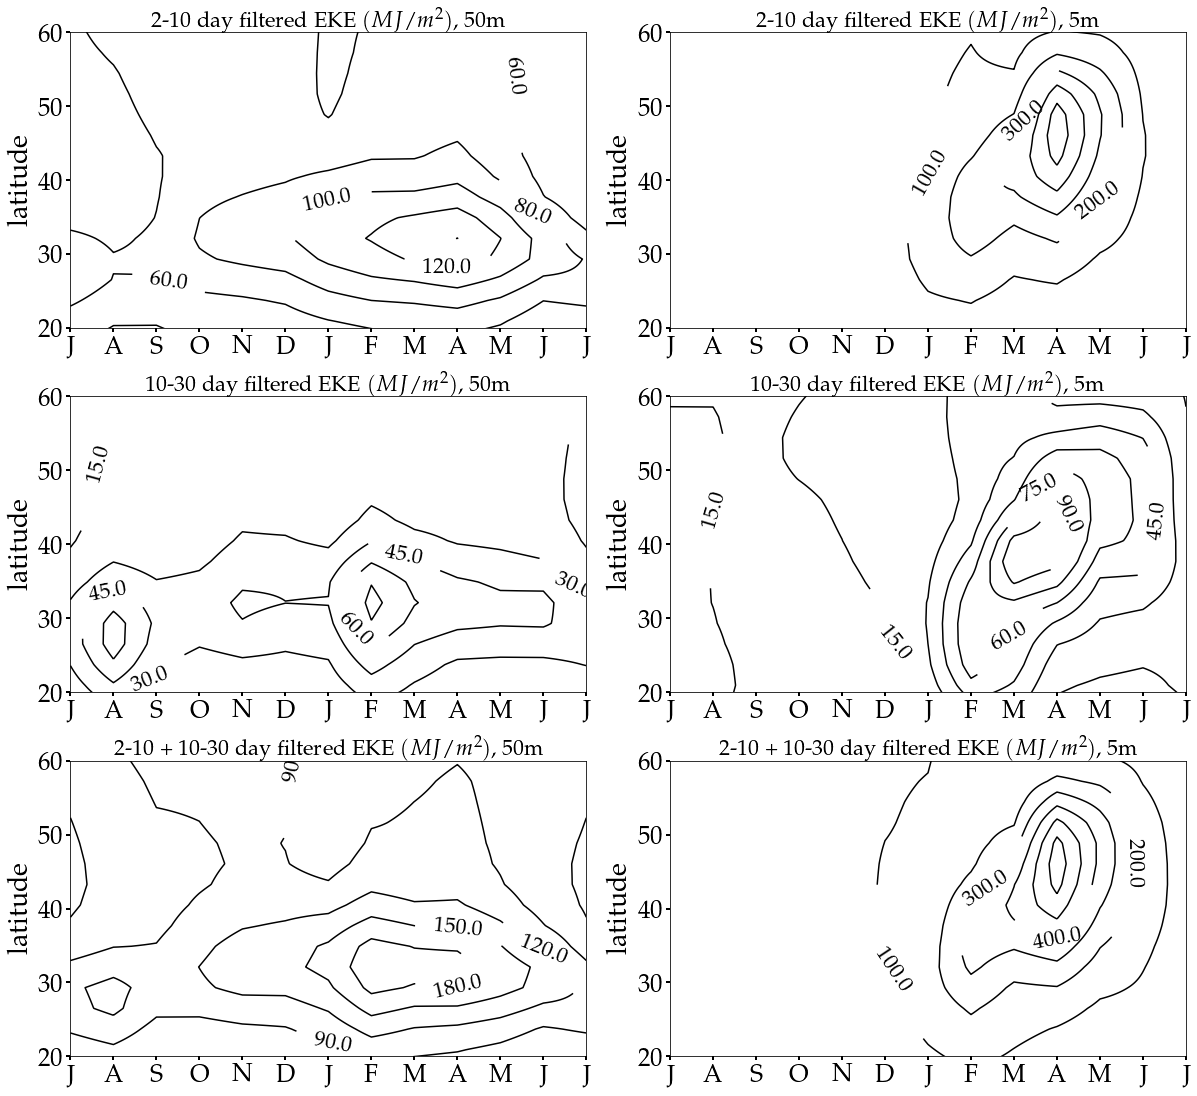

In [21]:
sumi  = EKE_Ha
mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),6)
mticks2 = (np.array(['J','A','S','O','N','D', 'J','F','M','A','M','J','J']))

depths=['5m', '50m']

def roll(x):
    y=np.roll(x[...,:-1],6,axis=-1)
    return np.append(y, y[...,0,None],axis=-1)
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.figure(figsize=(25,25))
NN = 6
# loc=loc-1
d=1
loc=22
n=0;
py.subplot(5,3,1)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'2-10 day filtered EKE $(MJ/m^2)$, '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

d=0
py.subplot(5,3,2)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'2-10 day filtered EKE $(MJ/m^2)$,  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

sumi  = EKE_Ia
d=1
n=0;
py.subplot(5,3,4)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10-30 day filtered EKE $(MJ/m^2)$, '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

d=0
py.subplot(5,3,5)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10-30 day filtered EKE $(MJ/m^2)$,  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

sumi  = EKE_Ia+EKE_Ha
d=1
n=0;
py.subplot(5,3,7)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'2-10 + 10-30 day filtered EKE $(MJ/m^2)$, '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

d=0
py.subplot(5,3,8)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'2-10 + 10-30 day filtered EKE $(MJ/m^2)$,  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)



py.tight_layout()

In [23]:
# py.figure(figsize=(15,4))
# py.subplot(1,2,1)
# py.contourf(range(13),lat_a,TEsensv_a[0,...]/10**15, vmin=0,cmap=cm.Reds); py.colorbar()
# py.plot(range(13), storm_pos[0,:], 'wo-')
# py.subplot(1,2,2)
# py.contourf(range(13),lat_a,TEsensv_a[1,...]/10**15, vmin=0,cmap=cm.Reds); py.colorbar()
# py.plot(range(13), storm_pos[1,:], 'wo-')

In [24]:
# m=m+1
# py.plot(lat_a, TEsensv_a[1,:,m]/10**15,'r-')
# py.plot(lat_a, TEmoistv_a[1,:,m]/10**15,'b-')
# py.plot(lat_a, TEpotv_a[1,:,m]/10**15,'g-')
# py.plot(lat_a, TE_a[1,:,m],'k-')
# print m

In [26]:
# m=0
# py.plot(lat_a, TEsensv_a[0,:,m]/10**15,'r-')
# py.plot(lat_a, TEmoistv_a[0,:,m]/10**15,'b-')
# py.plot(lat_a, TEpotv_a[0,:,m]/10**15,'g-')

In [27]:
Ihigh = inerp_at_max(flux=TE_a,lat=lat_a)

NameError: name 'TE_a' is not defined

In [ ]:
d=0
py.plot(range(13), Itotal[d,:]-Itotal[d,:-1].mean(), 'ro-', lw=3)
py.plot(range(13), Ihigh[d,:]-Ihigh[d,:-1].mean(), 'ro-')
py.plot(range(13), Iinter[d,:]-Iinter[d,:-1].mean(), 'ro--')

d=1
py.plot(range(13), Ihigh[d,:]-Ihigh[d,:-1].mean(), 'bo-')
py.plot(range(13), Iinter[d,:]-Iinter[d,:-1].mean(), 'bo--')
py.plot(range(13), Itotal[d,:]-Itotal[d,:-1].mean(), 'bo-', lw=3)


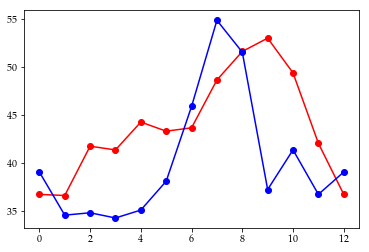

In [345]:
d=0
py.plot(range(13), storm_pos[d,:], 'ro-')
d=1
py.plot(range(13), storm_pos[d,:], 'bo-')

In [74]:
rot_rate  = 7.29*10**-5  ## rad/s
f = -2*rot_rate*np.sin(np.deg2rad(lat_a))[None,:,None,None]

v_dudt     = -lhs_term1/f
v_bar      = +lhs_term2/f

v_zetaV    = -lhs_term3/f
v_zetaVa   = -lhs_term3a/f
v_zetaVb   = -lhs_term3b/f

v_wdudp    =  -lhs_term4/f
v_wdudpa   =  -lhs_term4a/f
v_wdudpb   =  -lhs_term4b/f

v_divEMF   =  rhs_term1/f
v_divEMFa  =  rhs_term1a/f
v_divEMFb  =  rhs_term1b/f

v_du_wdp    =  rhs_term2/f
v_du_wdpa   =  rhs_term2a/f
v_du_wdpb   =  rhs_term2b/f

v_stress    =  stress_term/f


v_titles = [r'$\left[\overline{v}\right]$', \
          r'$+\frac{1}{f}\frac{\partial\left[\overline{u}\right]}{\partial t}$', \
          r'$-\overline{\frac{\left[\zeta\right]}{f}\left[v\right]}$',\
          r'$+\frac{1}{f}\overline{\left[\omega\right]\frac{\partial\left[u\right]}{\partial p}}$',\
          r'$+\frac{1}{f\ a\ cos^{2}\phi}\frac{\partial}{\partial\phi}\left(cos^{2}\left[\overline{u^{*}v^{*}}\right]\right)$', \
          r'$+\frac{1}{f}\frac{\partial\left[\overline{u^{*}w^{*}}\right]}{\partial p}$',\
          r'$+\frac{1}{f}\frac{\partial\left[\overline{\tau}\right]}{\partial p}$']

v_titles_delta = [r'$\Delta\left[\overline{v}\right]$', \
          r'$+\Delta\frac{1}{f}\frac{\partial\left[\overline{u}\right]}{\partial t}$', \
          r'$-\Delta\overline{\frac{\left[\zeta\right]}{f}\left[v\right]}$',\
          r'$+\Delta\frac{1}{f}\overline{\left[\omega\right]\frac{\partial\left[u\right]}{\partial p}}$',\
          r'$+\Delta\frac{1}{f\ a\ cos^{2}\phi}\frac{\partial}{\partial\phi}\left(cos^{2}\left[\overline{u^{*}v^{*}}\right]\right)$', \
          r'$+\Delta\frac{1}{f}\frac{\partial\left[\overline{u^{*}w^{*}}\right]}{\partial p}$',\
          r'$+\Delta\frac{1}{f}\frac{\partial\left[\overline{\tau}\right]}{\partial p}$']



In [75]:
def at_storm(X):
    return np.array([inerp_at_max(X[...,lev,:],lat_a) for lev in range(len(pres))]).transpose(1,0,2)

P_lhs_term1_v     = at_storm(lhs_term1)*10**5
P_lhs_term2_v     = at_storm(lhs_term2)*10**5
P_lhs_term3_v     = at_storm(lhs_term3)*10**5
P_lhs_term4_v     = at_storm(lhs_term4)*10**5

P_rhs_term1_v     = at_storm(rhs_term1)*10**5
P_rhs_term2_v     = at_storm(rhs_term2)*10**5
P_rhs_term3_v     = at_storm(stress_term)*10**5

P_v_dudt      = at_storm(v_dudt)
P_v_bar       = at_storm(v_bar)
P_v_zetaV     = at_storm(v_zetaV)
P_v_wdudp     = at_storm(v_wdudp)

P_v_divEMF     = at_storm(v_divEMF)
P_v_du_wdp     = at_storm(v_du_wdp)
P_v_stress     = at_storm(v_stress)

In [76]:
P_lhs_term1_v.shape
P_lhs_term1_v.shape[-1]

13

In [77]:
def eddy(X):
    return X-X[...,:-1].mean(axis=-1)[...,None]

def plot_at_storm_pos(X=P_lhs_term1_v, case=0, expi=0, p= 8, C='r', ls='-', tit=titles):
    fs =20
    py.plot(range(X.shape[-1]), eddy(X)[expi, p, :], 'o'+ls, \
            label=tit[case], lw=3, c=C ); 
    py.axhline(0, color='k')
    py.title(exp_names[expi]+'  ('+str(int(pres[p]*100))+' hPa)', fontsize=fs, y=1.01)
    py.tight_layout()
    
    
def plot_together(E=0, P=8, show=1):
    plot_at_storm_pos(X=P_lhs_term1_v, case=0, expi=E, p= P, C='y')
    plot_at_storm_pos(X=P_lhs_term2_v, case=1, expi=E, p= P, C='r')
    plot_at_storm_pos(X=P_lhs_term3_v, case=2, expi=E, p= P, C='g')
    plot_at_storm_pos(X=P_lhs_term4_v, case=3, expi=E, p= P, C='c')
    plot_at_storm_pos(X=P_rhs_term1_v, case=4, expi=E, p= P, C='b',ls='--')
    plot_at_storm_pos(X=P_rhs_term2_v, case=5, expi=E, p= P, C='darkorange',ls='--')
    plot_at_storm_pos(X=P_rhs_term3_v, case=6, expi=E, p= P, C='k',ls='--')
    py.ylim(-8,8)
    
def plot_together_V(E=0, P=8, show=1):
    plot_at_storm_pos(X=P_v_bar, case=0, expi=E, p= P, C='r', tit=v_titles)
    plot_at_storm_pos(X=P_v_dudt, case=1, expi=E, p= P, C='y', tit=v_titles)
    plot_at_storm_pos(X=P_v_zetaV, case=2, expi=E, p= P, C='g', tit=v_titles)
    plot_at_storm_pos(X=P_v_wdudp, case=3, expi=E, p= P, C='c', tit=v_titles)
    plot_at_storm_pos(X=P_v_divEMF, case=4, expi=E, p= P, C='b',ls='-', tit=v_titles)
    plot_at_storm_pos(X=P_v_du_wdp, case=5, expi=E, p= P, C='darkorange',ls='-', tit=v_titles)
    plot_at_storm_pos(X=P_v_stress, case=6, expi=E, p= P, C='k',ls='-', tit=v_titles)
    mticks2 = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(13), (mticks2),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylim(-2,2)
    
def plot_together_V_delta(E=0, P=8, show=1):
    plot_at_storm_pos(X=P_v_bar, case=0, expi=E, p= P, C='r', tit=v_titles_delta)
    plot_at_storm_pos(X=P_v_dudt, case=1, expi=E, p= P, C='y', tit=v_titles_delta)
    plot_at_storm_pos(X=P_v_zetaV, case=2, expi=E, p= P, C='g', tit=v_titles_delta)
    plot_at_storm_pos(X=P_v_wdudp, case=3, expi=E, p= P, C='c', tit=v_titles_delta)
    plot_at_storm_pos(X=P_v_divEMF, case=4, expi=E, p= P, C='b',ls='-', tit=v_titles_delta)
    plot_at_storm_pos(X=P_v_du_wdp, case=5, expi=E, p= P, C='darkorange',ls='-', tit=v_titles_delta)
    plot_at_storm_pos(X=P_v_stress, case=6, expi=E, p= P, C='k',ls='-', tit=v_titles_delta)
    mticks2 = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(13), (mticks2),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylim(-0.8,0.8)

  

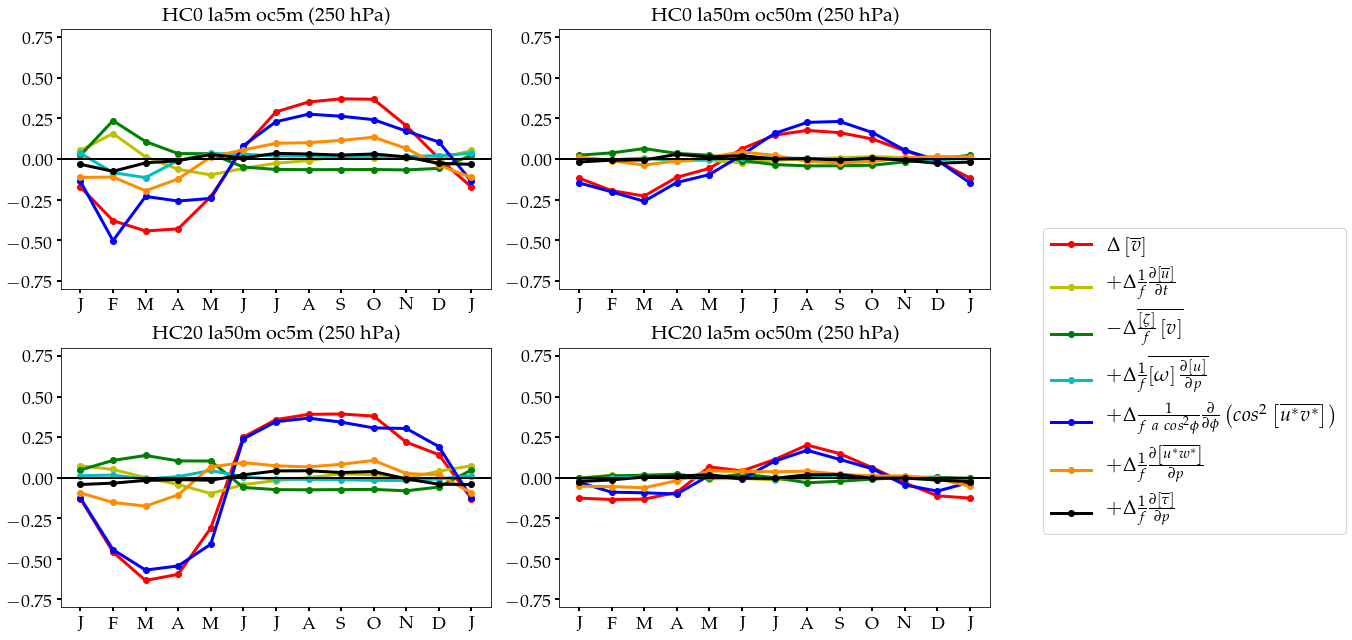

In [78]:
P=8
py.figure(figsize=(14,9))
py.subplot(2,2,1)
plot_together_V_delta(E=0, P=P, show=0)

py.subplot(2,2,2)
plot_together_V_delta(E=1, P=P, show=0)

py.subplot(2,2,4)
plot_together_V_delta(E=2, P=P, show=1)
py.legend(loc='best',bbox_to_anchor=(1.1, 1.5), fontsize=20)

py.subplot(2,2,3)
plot_together_V_delta(E=3, P=P, show=0)


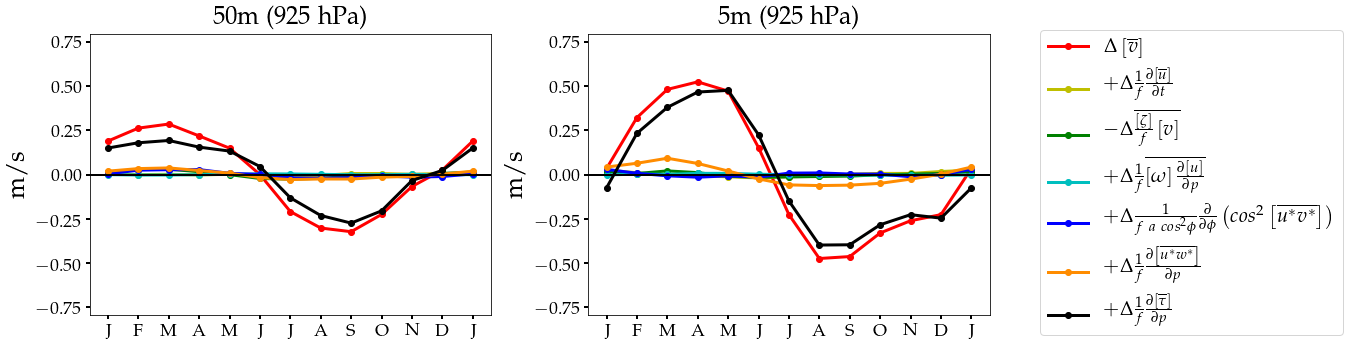

In [128]:
P=-4
py.figure(figsize=(14,9))
py.subplot(2,2,2)
plot_together_V_delta(E=0, P=P, show=0)
py.ylabel('m/s',fontsize=25)
py.title('5m (925 hPa)',fontsize=25 )
#py.legend(loc='best',bbox_to_anchor=(1.1,1.05),fontsize=20, ncol=2)
    
py.subplot(2,2,1)
plot_together_V_delta(E=1, P=P, show=0)
py.ylabel('m/s', fontsize=25)
py.title('50m (925 hPa)', fontsize=25)

py.tight_layout()
py.savefig('Sep8_Figures/v+925_at_storm.pdf',bbox_to_inches='tight')

# py.subplot(2,2,4)
# plot_together_V_delta(E=2, P=P, show=1)
# py.legend(loc='best',bbox_to_anchor=(1.1, 1.5), fontsize=20)

# py.subplot(2,2,3)
# plot_together_V_delta(E=3, P=P, show=0)


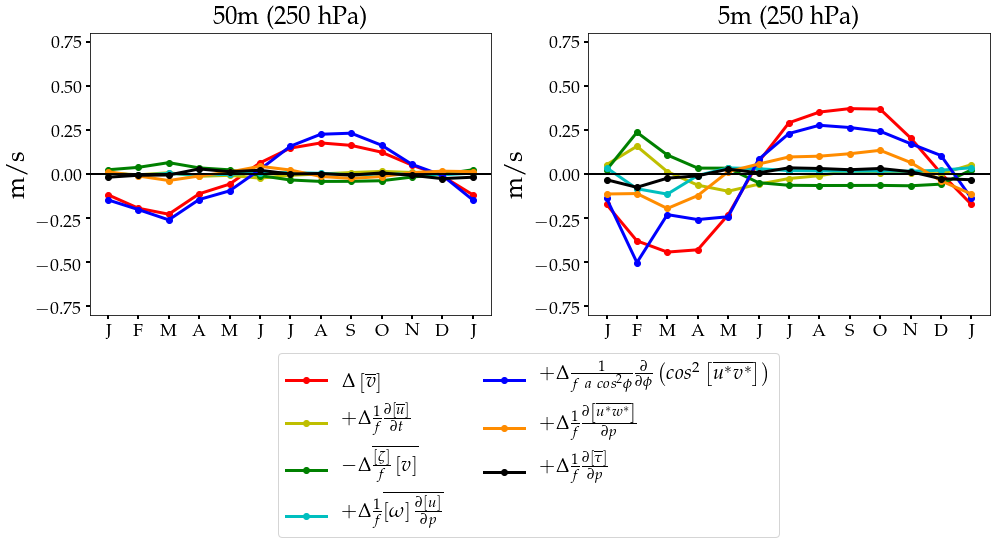

In [139]:
P=8
py.figure(figsize=(14,9))
py.subplot(2,2,2)
plot_together_V_delta(E=0, P=P, show=0)
py.ylabel('m/s',fontsize=25)
py.title('5m (250 hPa)',fontsize=25 )
py.legend(loc='best',bbox_to_anchor=(0.5,-0.1), fontsize=20, ncol=2)
    
py.subplot(2,2,1)
plot_together_V_delta(E=1, P=P, show=0)
py.ylabel('m/s', fontsize=25)
py.title('50m (250 hPa)', fontsize=25)

py.tight_layout()
py.savefig('Sep8_Figures/v+250_at_storm.pdf',bbox_to_inches='tight')

# py.subplot(2,2,4)
# plot_together_V_delta(E=2, P=P, show=1)
# py.legend(loc='best',bbox_to_anchor=(1.1, 1.5), fontsize=20)

# py.subplot(2,2,3)
# plot_together_V_delta(E=3, P=P, show=0)


In [80]:
P_v_dudt      = at_storm(v_dudt)
P_v_bar       = at_storm(v_bar)
P_v_zetaV     = at_storm(v_zetaV)
P_v_wdudp     = at_storm(v_wdudp)

P_v_divEMF     = at_storm(v_divEMF)
P_v_du_wdp     = at_storm(v_du_wdp)
P_v_stress     = at_storm(v_stress)

In [81]:
def plot_contours_v_decomposed(expi=0, p= 8, max=8, depth='5m'):
    ind=((lat_a>=30) & (lat_a<=80))
    MONTHS = lhs_term1.shape[-1]
    fs =20
    py.figure(figsize=(15,15))
    ranges = np.arange(-max,max+0.2,0.2)
    py.subplot(4,3,1)
    py.contourf(range(MONTHS), lat_a[ind], v_bar[expi, ind, p, :], ranges, cmap=cm.RdBu_r); py.colorbar()
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title(v_titles[0], fontsize=fs)
    py.subplot(4,3,2)
    py.contourf(range(MONTHS), lat_a[ind], v_dudt[expi, ind, p, :], ranges, cmap=cm.RdBu_r); py.colorbar()
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title(v_titles[1], fontsize=fs)
    py.subplot(4,3,3)
    py.contourf(range(MONTHS), lat_a[ind], v_zetaV[expi, ind, p, :], ranges, cmap=cm.RdBu_r); py.colorbar()
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title(v_titles[2], fontsize=fs)
    py.subplot(4,3,4)
    py.contourf(range(MONTHS), lat_a[ind], v_wdudp[expi, ind, p, :], ranges, cmap=cm.RdBu_r); py.colorbar()
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title(titles[3], fontsize=fs)

    py.subplot(4,3,5)
    py.contourf(range(MONTHS), lat_a[ind], v_divEMF[expi, ind, p, :], ranges, cmap=cm.RdBu_r); py.colorbar()
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title(v_titles[4], fontsize=fs)
    py.subplot(4,3,6)
    py.contourf(range(MONTHS), lat_a[ind], v_du_wdp[expi, ind, p, :], ranges, cmap=cm.RdBu_r); py.colorbar()
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title(v_titles[5], fontsize=fs)
    py.subplot(4,3,7)
    py.contourf(range(MONTHS), lat_a[ind], v_stress[expi, ind, p, :], ranges, cmap=cm.RdBu_r); py.colorbar()
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title(v_titles[6], fontsize=fs)
    py.suptitle(depth+' --- Decomposition of V [m/s] at '+str(int(pres[p]*100))+' hPa', fontsize=fs, y=1.01)
    py.tight_layout()

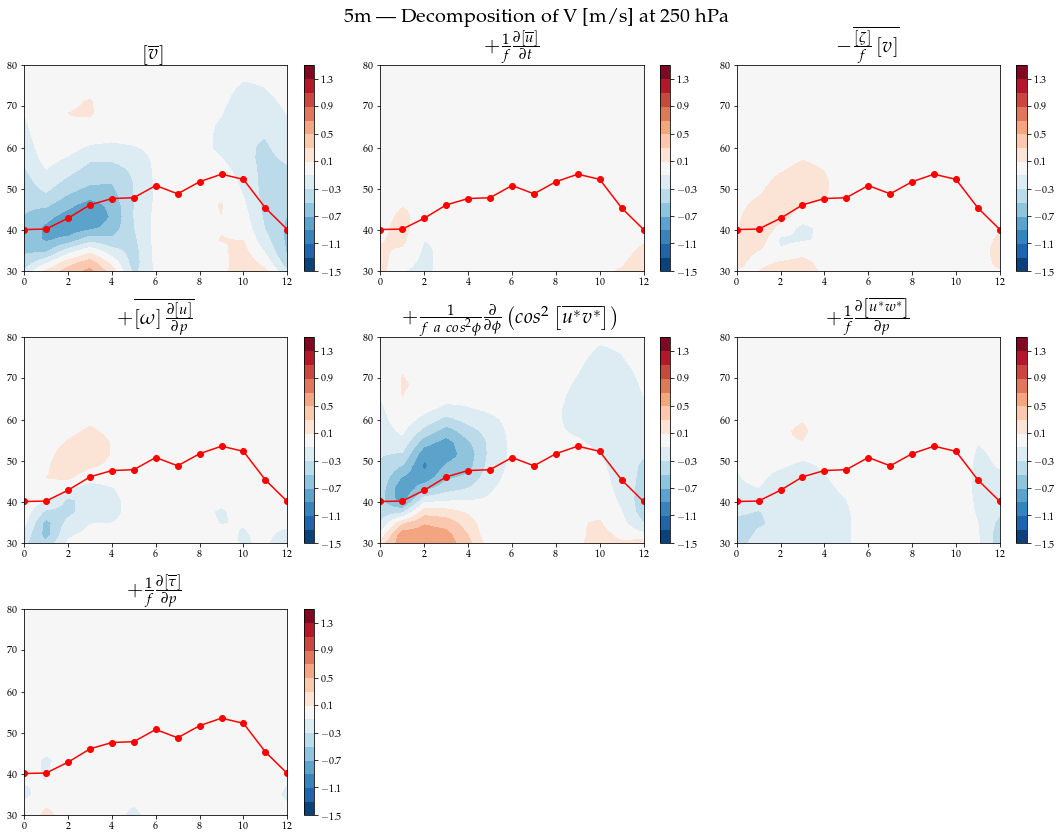

In [82]:
plot_contours_v_decomposed(expi=0, p= 8, max=1.5, depth='5m')

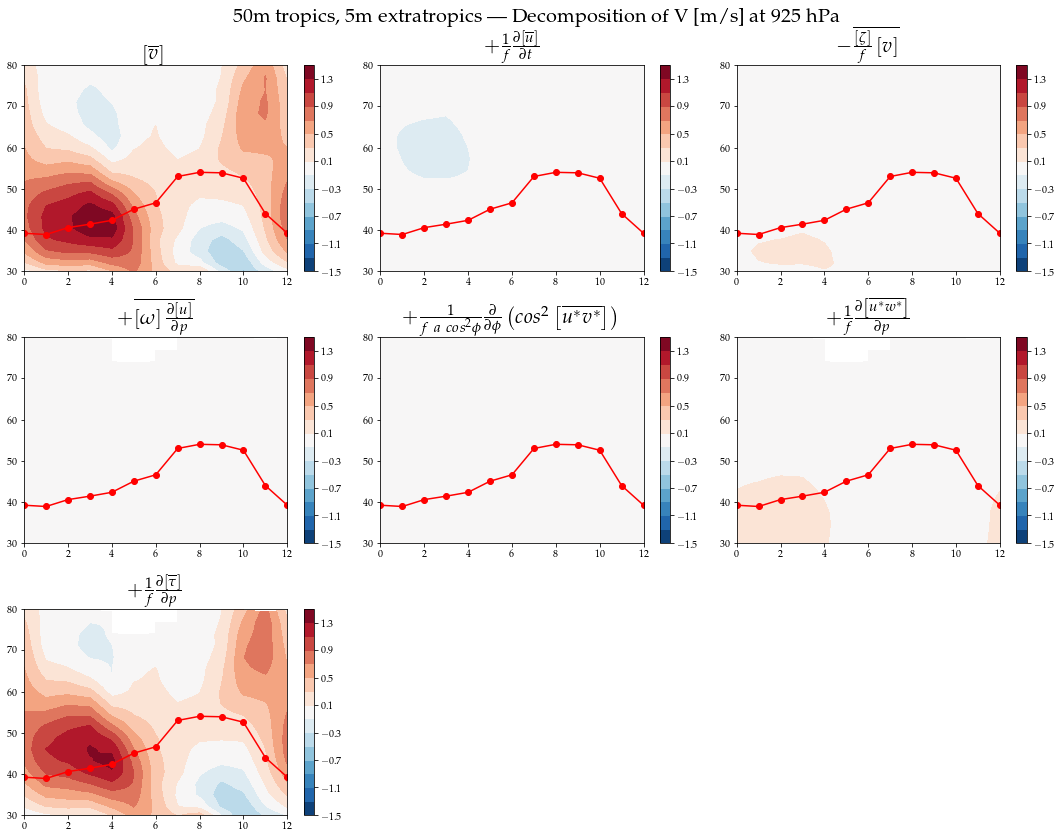

In [83]:
plot_contours_v_decomposed(expi=3, p= -4, max=1.5, depth='50m tropics, 5m extratropics')

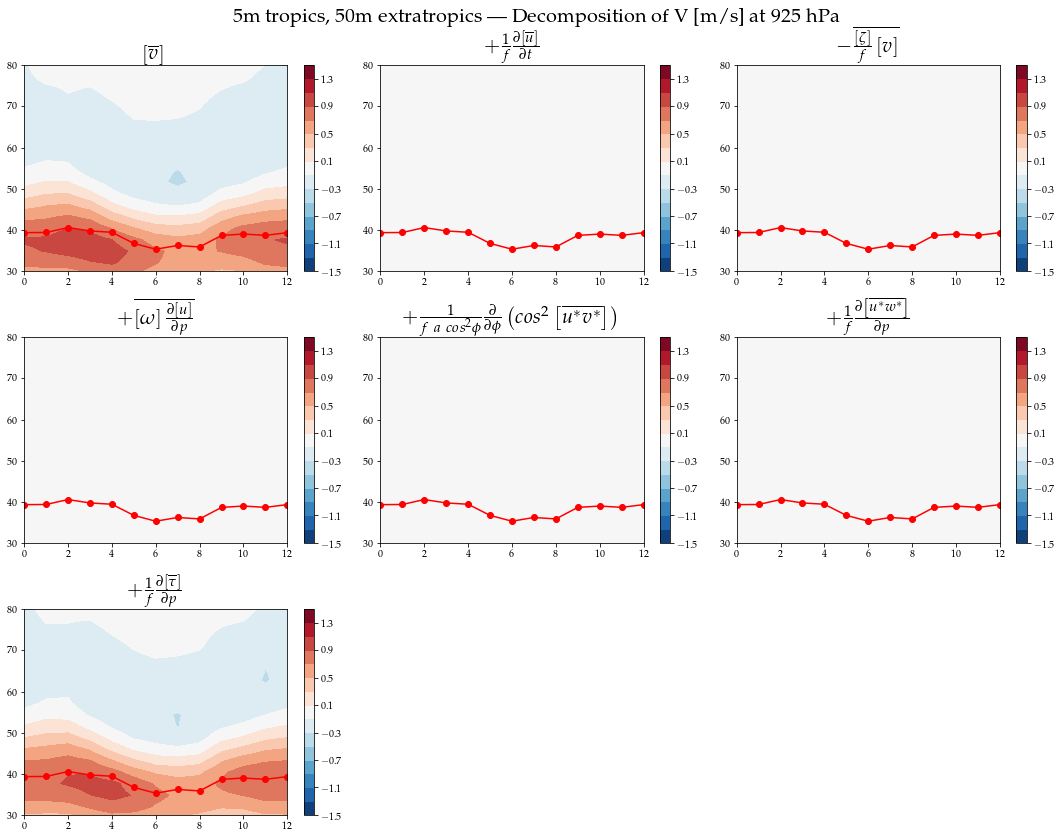

In [84]:
plot_contours_v_decomposed(expi=2, p= -4, max=1.5, depth='5m tropics, 50m extratropics')

In [85]:
len(v_titles)

7

In [86]:
def plot_contours_v_LHS_RHS(expi=0, p= 8, max=8, depth='5m'):
    ind=((lat_a>=30) & (lat_a<=80))
    MONTHS = lhs_term1.shape[-1]
    fs =20
    py.figure(figsize=(18,6))
    ranges = np.arange(-max,max+0.15,0.15)
    py.subplot(1,3,1)
    py.contourf(range(MONTHS), lat_a[ind], v_bar[expi, ind, p, :], ranges, cmap=cm.RdBu_r); #py.colorbar()
    c=py.contour(range(MONTHS), lat_a[ind], v_bar[expi, ind, p, :], ranges, colors='k')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=20)
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title(v_titles[0], fontsize=fs)
    py.tick_params(labelsize=18,size=4,width=2)
    
    py.subplot(1,3,2)
    
    RHS =  v_dudt+v_zetaV+v_wdudp+v_divEMF+v_du_wdp #+ v_stress
    
    py.contourf(range(MONTHS), lat_a[ind], RHS[expi, ind, p, :], ranges, cmap=cm.RdBu_r); #py.colorbar()
    c=py.contour(range(MONTHS), lat_a[ind], RHS[expi, ind, p, :], ranges, colors='k')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=20)
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title(v_titles[1]+v_titles[2]+v_titles[3]+'\n'+v_titles[4]+v_titles[5], fontsize=fs)
    py.tick_params(labelsize=18,size=4,width=2)
    
    py.subplot(1,3,3)
    
    RHS =  v_dudt+v_zetaV+v_wdudp+v_divEMF+v_du_wdp #+ v_stress
    
    py.contourf(range(MONTHS), lat_a[ind], (v_bar-RHS)[expi, ind, p, :], ranges, cmap=cm.RdBu_r);# py.colorbar()
    c= py.contour(range(MONTHS), lat_a[ind], (v_bar-RHS)[expi, ind, p, :], ranges, colors='k')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=20)
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title('residual='+v_titles[0]+'- RHS', fontsize=fs)

    py.tick_params(labelsize=18,size=4,width=2)
    py.suptitle(depth+' --- Decomposition of V [m/s] at '+str(int(pres[p]*100))+' hPa', fontsize=fs, y=1.05)
    py.tight_layout()
    
def plot_v_LHS_equal_RHS(expi=0, p= 8):
    fs =20
    py.figure(figsize=(8,4))
    py.plot(lat_a, (lhs_term1+lhs_term2+lhs_term4+lhs_term3)[expi, :, p, :-1].mean(axis=-1)*10**5, \
            label=titles[0]+titles[1]+titles[2]+titles[3], lw=3); 
    py.plot(lat_a, (rhs_term1+rhs_term2+stress_term)[expi, :, p, :-1].mean(axis=-1)*10**5, \
            label=titles[4]+titles[5]+titles[6], lw=3, ls='--'); 
    py.axhline(0, color='k')
    py.title(exp_names[expi]+'  ('+str(int(pres[p]*100))+' hPa)', fontsize=fs, y=1.01)
    py.legend(loc='best',bbox_to_anchor=(1, 1.05), fontsize=20)
    py.tight_layout()

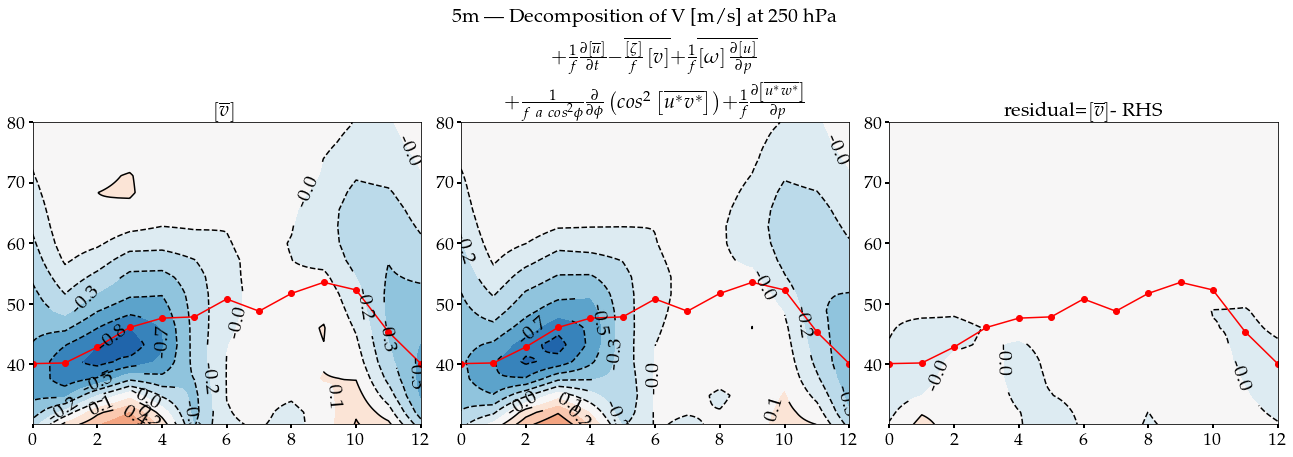

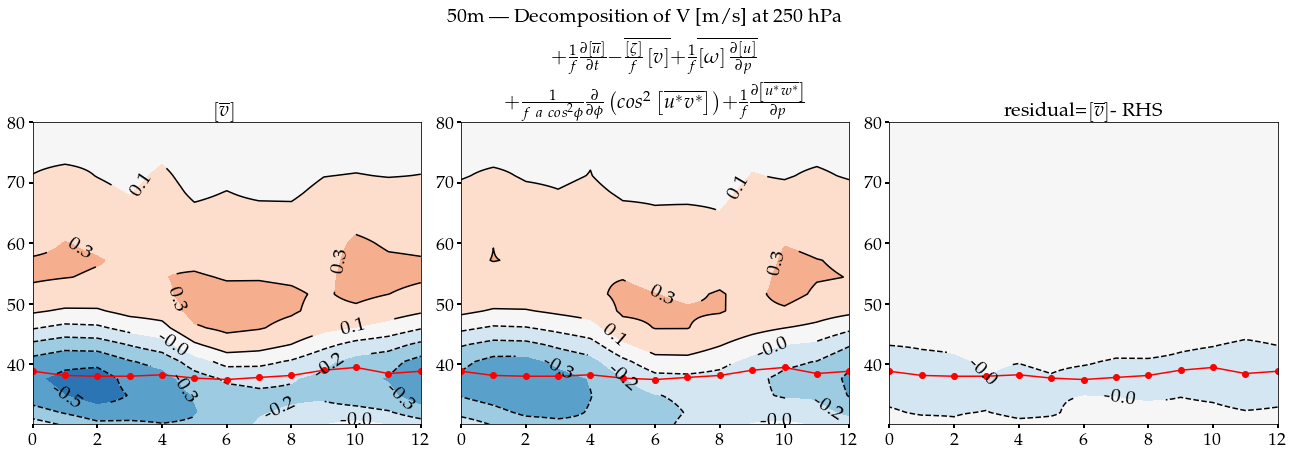

In [87]:
plot_contours_v_LHS_RHS(expi=0, p= 8, max=1.1, depth='5m')

plot_contours_v_LHS_RHS(expi=1, p= 8, max=0.8, depth='50m')

In [88]:
v_titles[0]

'$\\left[\\overline{v}\\right]$'

In [89]:
def plot_contours_v_mean_eddy(expi=0, p= 8, max=8, depth='5m'):
    ind=((lat_a>=30) & (lat_a<=80))
    MONTHS = lhs_term1.shape[-1]
    fs =25
    fs1=22
    py.figure(figsize=(15,10))
    ranges = np.arange(-max,max+0.15,0.15)
    py.subplot(2,2,1)
    py.contourf(range(MONTHS), lat_a[ind], v_bar[expi, ind, p, :], ranges, cmap=cm.RdBu_r); #py.colorbar()
    c=py.contour(range(MONTHS), lat_a[ind], v_bar[expi, ind, p, :], ranges, colors='k')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=20)
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
    py.title(v_titles[0], fontsize=fs, y=1.02)
    py.tick_params(labelsize=18,size=4,width=2)
    mticks2 = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(13), (mticks2),fontsize=18)
    py.ylabel('Latitude', fontsize=fs1)
    
    py.subplot(2,2,2)
    
    mean =  v_dudt+v_zetaV+v_wdudp
    
    py.contourf(range(MONTHS), lat_a[ind], mean[expi, ind, p, :], ranges, cmap=cm.RdBu_r); #py.colorbar()
    c=py.contour(range(MONTHS), lat_a[ind], mean[expi, ind, p, :], ranges, colors='k')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=20)
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
#     py.title(v_titles[1]+v_titles[2]+v_titles[3], fontsize=fs)
    py.title(r'$\left[\overline{v_{mean}}\right]$', fontsize=fs, y=1.02)
    py.tick_params(labelsize=18,size=4,width=2)
    mticks2 = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(13), (mticks2),fontsize=18)
    py.ylabel('Latitude', fontsize=fs1)
    
    
    py.subplot(2,2,3)
    
    eddy =  v_divEMF+v_du_wdp #+ v_stress
    
    py.contourf(range(MONTHS), lat_a[ind],  eddy[expi, ind, p, :], ranges, cmap=cm.RdBu_r); #py.colorbar()
    c=py.contour(range(MONTHS), lat_a[ind], eddy[expi, ind, p, :], ranges, colors='k')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=20)
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
#     py.title(v_titles[4]+v_titles[5], fontsize=fs)
    py.title(r'$\left[\overline{v_{eddy}}\right]$', fontsize=fs, y=1.02)
    py.tick_params(labelsize=18,size=4,width=2)
    mticks2 = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(13), (mticks2),fontsize=18)
    py.ylabel('Latitude', fontsize=fs1)

    
    py.subplot(2,2,4)
    
    RHS =  v_dudt+v_zetaV+v_wdudp+v_divEMF+v_du_wdp #+ v_stress
    
    py.contourf(range(MONTHS), lat_a[ind], (v_bar-(mean+eddy))[expi, ind, p, :], ranges, cmap=cm.RdBu_r);# py.colorbar()
    c= py.contour(range(MONTHS), lat_a[ind], (v_bar-(mean+eddy))[expi, ind, p, :], ranges, colors='k')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=20)
    py.plot(range(MONTHS), storm_pos[expi,:], 'ro-')
#     py.title('residual='+v_titles[0]+r'- ($v_{mean}$+$v_{eddy}$)', fontsize=fs)
    py.title('residual', fontsize=fs, y=1.02)
    mticks2 = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(13), (mticks2),fontsize=18)
    py.ylabel('Latitude', fontsize=fs1)

    py.tick_params(labelsize=18,size=4,width=2)
    py.suptitle(str(int(pres[p]*100))+' hPa', fontsize=fs, y=1.05)
    py.tight_layout()
    

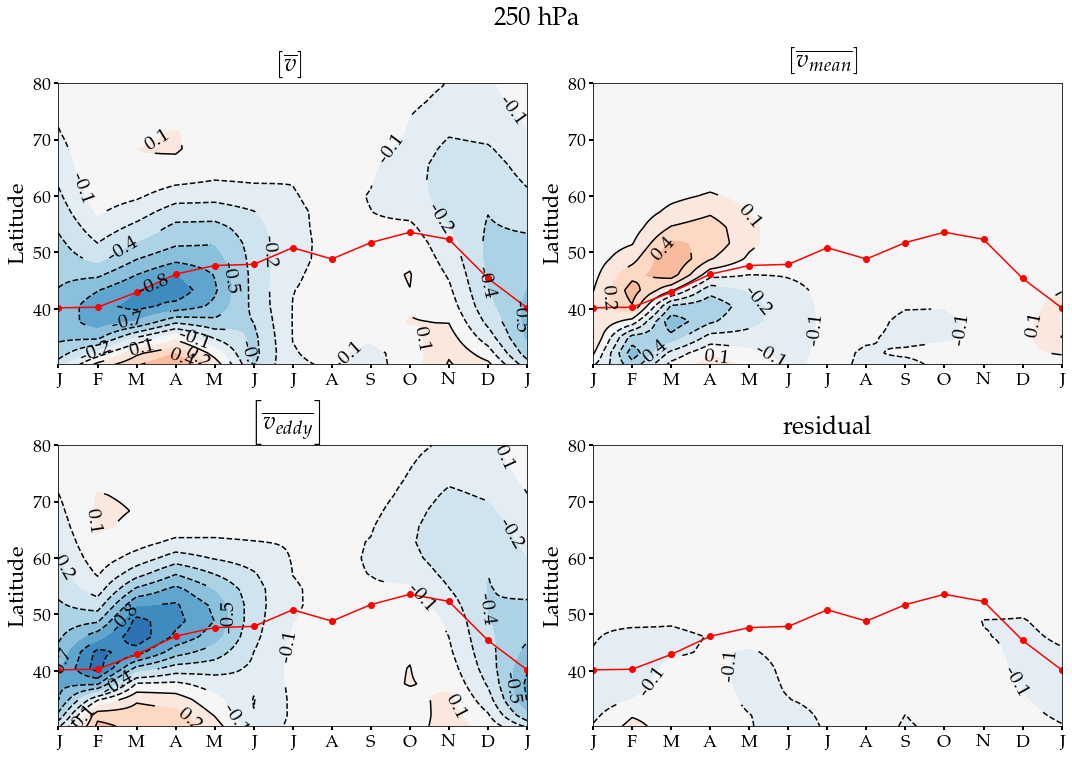

In [90]:
plot_contours_v_mean_eddy(expi=0, p= 8, max=1.4, depth='5m')
py.savefig('Sep8_Figures/5m.pdf')

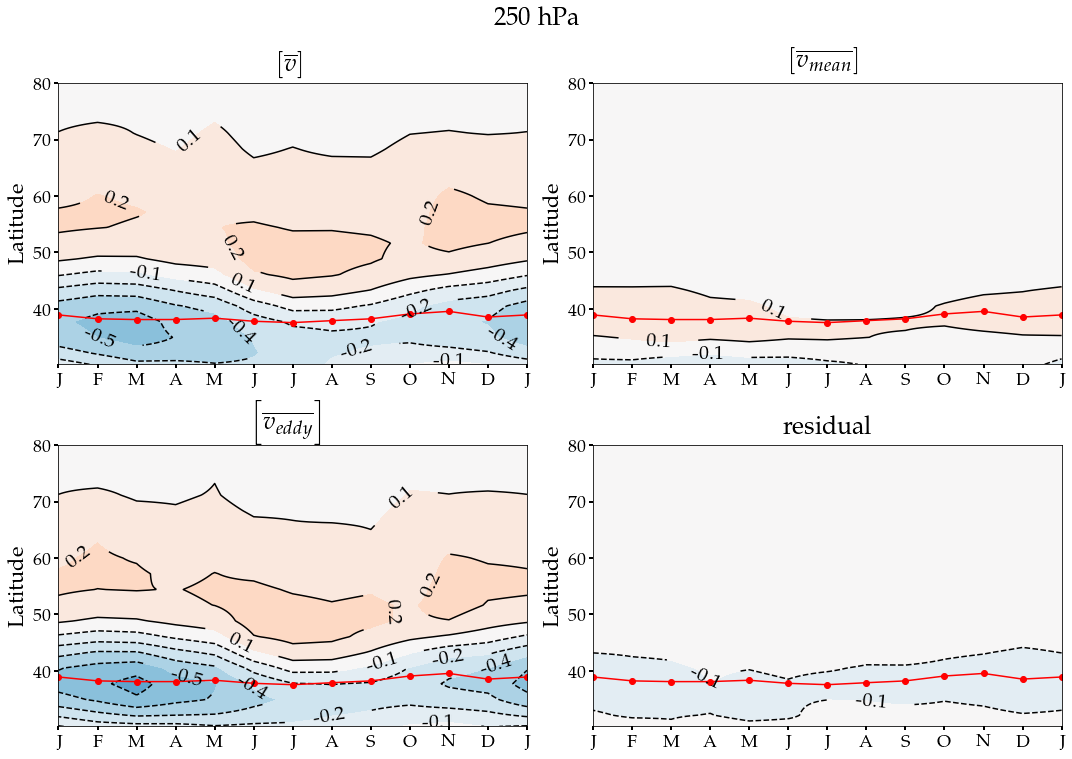

In [142]:
plot_contours_v_mean_eddy(expi=1, p= 8, max=1.4, depth='50m')
py.savefig('Sep8_Figures/50m.pdf')

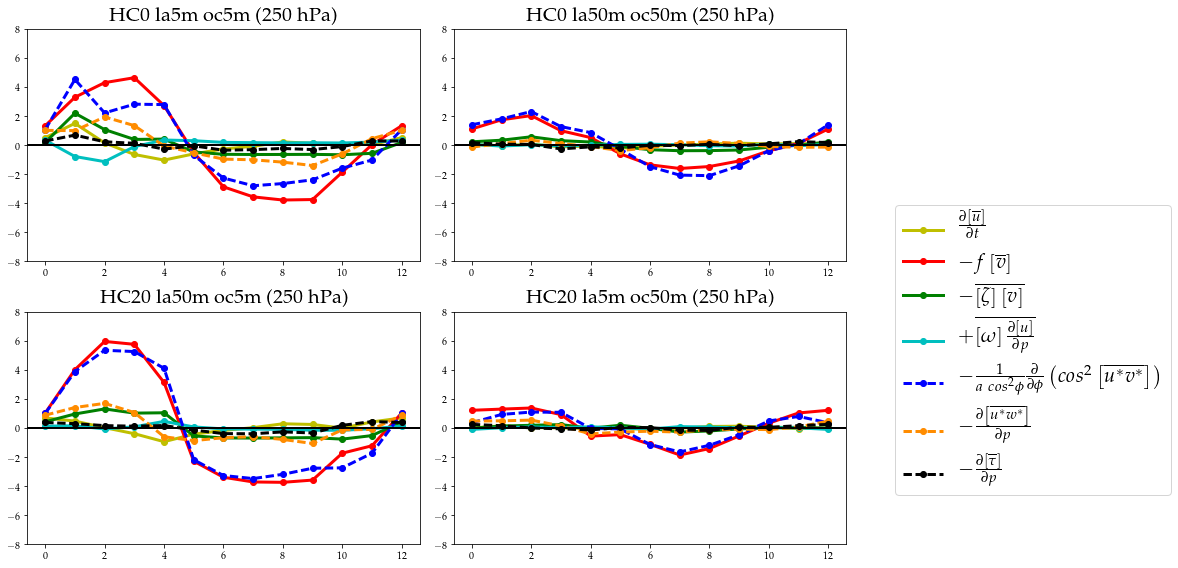

In [92]:
P=8
py.figure(figsize=(12,8))
py.subplot(2,2,1)
plot_together(E=0, P=P, show=0)

py.subplot(2,2,2)
plot_together(E=1, P=P, show=0)

py.subplot(2,2,4)
plot_together(E=2, P=P, show=1)
py.legend(loc='best',bbox_to_anchor=(1.1, 1.5), fontsize=20)

py.subplot(2,2,3)
plot_together(E=3, P=P, show=0)


In [93]:
# P=-4
# py.figure(figsize=(12,8))
# py.subplot(2,2,1)
# plot_together(E=0, P=P, show=0)

# py.subplot(2,2,2)
# plot_together(E=1, P=P, show=0)

# py.subplot(2,2,4)
# plot_together(E=2, P=P, show=1)
# py.legend(loc='best',bbox_to_anchor=(1.1, 1.5), fontsize=20)

# py.subplot(2,2,3)
# plot_together(E=3, P=P, show=0)


In [94]:
def plot_LHS_equal_RHS(expi=0, p= 8):
    fs =20
    py.figure(figsize=(8,4))
    py.plot(lat_a, (lhs_term1+lhs_term2+lhs_term4+lhs_term3)[expi, :, p, :-1].mean(axis=-1)*10**5, \
            label=titles[0]+titles[1]+titles[2]+titles[3], lw=3); 
    py.plot(lat_a, (rhs_term1+rhs_term2+stress_term)[expi, :, p, :-1].mean(axis=-1)*10**5, \
            label=titles[4]+titles[5]+titles[6], lw=3, ls='--'); 
    py.axhline(0, color='k')
    py.title(exp_names[expi]+'  ('+str(int(pres[p]*100))+' hPa)', fontsize=fs, y=1.01)
    py.legend(loc='best',bbox_to_anchor=(1, 1.05), fontsize=20)
    py.tight_layout()

In [95]:
# p=-1
# py.plot(lat_a, rhs_term3a[0, :, p, :-1].mean(axis=-1)*10**5, label='residual', lw=3, c='r')
# py.plot(lat_a, rhs_term3[0, :, p, :-1].mean(axis=-1)*10**5, label='residual', lw=3, c='b')
# py.plot(lat_a, rhs_term3b[0, :, p, :-1].mean(axis=-1)*10**5, label='residual', lw=3, c='g')
# py.plot(lat_a, rhs_term3c[0, :, p, :-1].mean(axis=-1)*10**5, label='residual', lw=3, c='y')

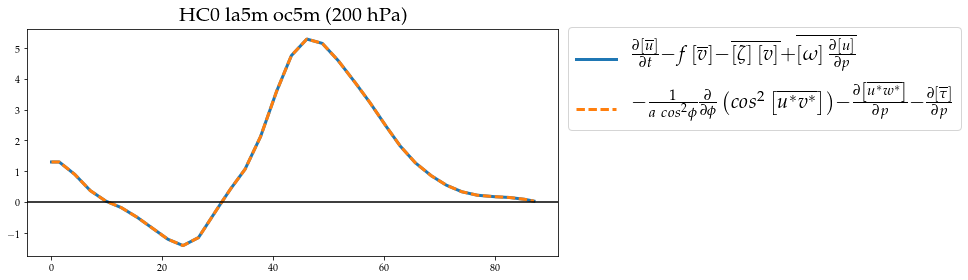

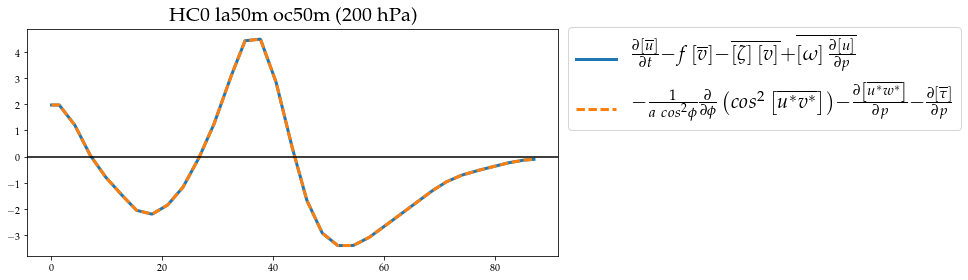

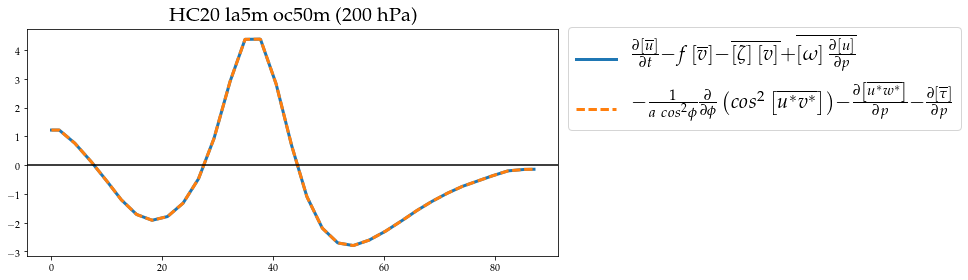

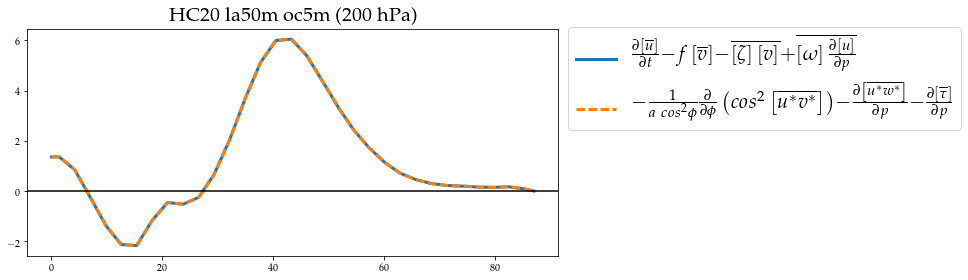

In [96]:
P=7
plot_LHS_equal_RHS(expi=0, p= P)
plot_LHS_equal_RHS(expi=1, p= P)
plot_LHS_equal_RHS(expi=2, p= P)
plot_LHS_equal_RHS(expi=3, p= P)

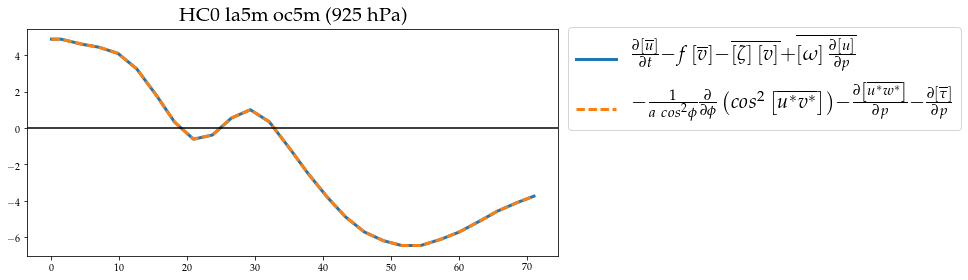

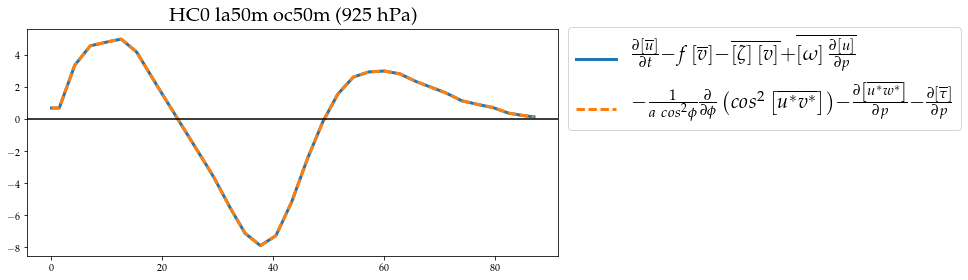

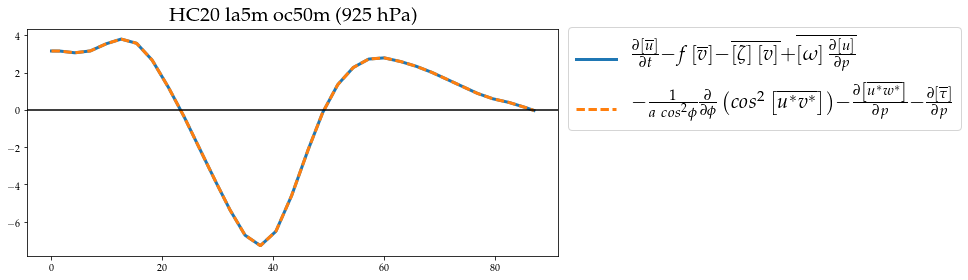

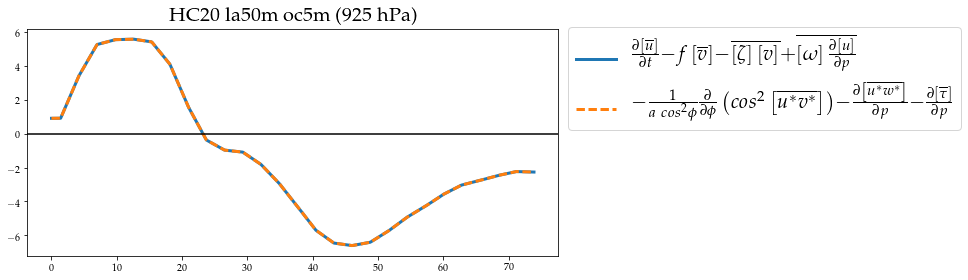

In [97]:
P=-4
plot_LHS_equal_RHS(expi=0, p= P)
plot_LHS_equal_RHS(expi=1, p= P)
plot_LHS_equal_RHS(expi=2, p= P)
plot_LHS_equal_RHS(expi=3, p= P)

In [98]:
def plot_annual_mean(expi=0, p= 8):
    fs =20
    py.figure(figsize=(8,4))
    py.plot(lat_a, lhs_term1[expi, :, p, :-1].mean(axis=-1)*10**5, label=titles[0], lw=3); 
    py.plot(lat_a, lhs_term2[expi, :, p, :-1].mean(axis=-1)*10**5, label=titles[1], lw=3); 
    py.plot(lat_a, lhs_term3[expi, :, p, :-1].mean(axis=-1)*10**5, label=titles[2], lw=3);    
    py.plot(lat_a, lhs_term4[expi, :, p, :-1].mean(axis=-1)*10**5, label=titles[3], lw=3);    

    py.plot(lat_a, rhs_term1[expi, :, p, :-1].mean(axis=-1)*10**5, label=titles[4], lw=3, ls='--'); 
    py.plot(lat_a, rhs_term2[expi, :, p, :-1].mean(axis=-1)*10**5, label=titles[5], lw=3, ls='--');
    py.plot(lat_a, stress_term[expi, :, p, :-1].mean(axis=-1)*10**5, label=titles[6], lw=3, ls='--');
    
#     py.plot(lat_a, residual[expi, :, p, :-1].mean(axis=-1)*10**5, label='residual', lw=3, c='k');
    py.title(exp_names[expi]+'  ('+str(int(pres[p]*100))+' hPa)', fontsize=fs, y=1.01)
    py.legend(loc='best',bbox_to_anchor=(1, 1.05), fontsize=20)
    py.axhline(0, color='k')
    py.tight_layout()

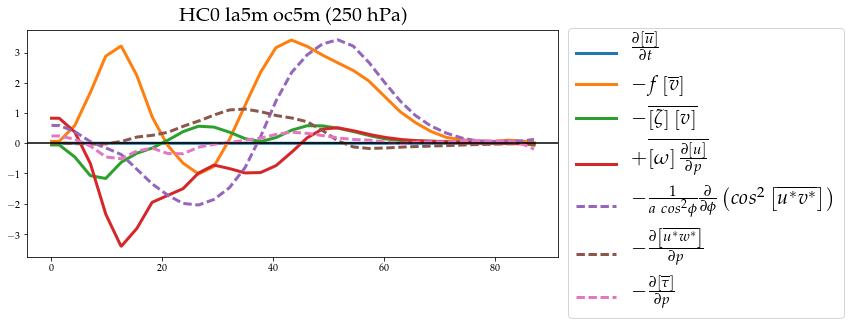

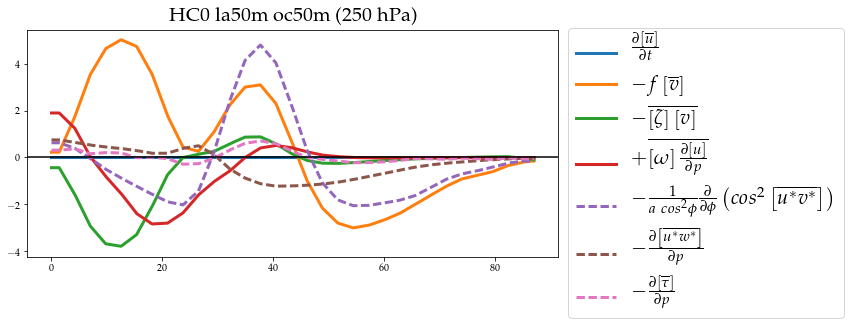

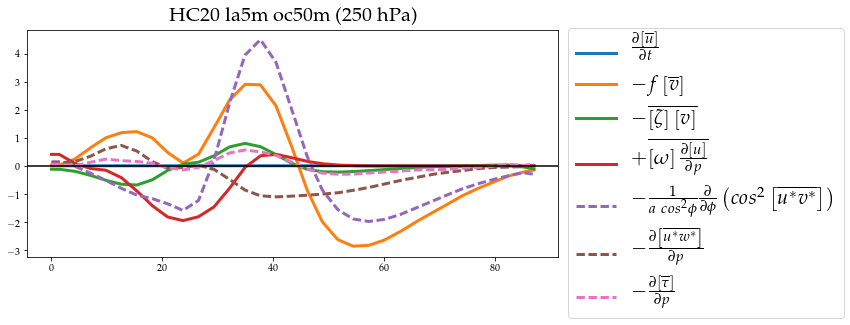

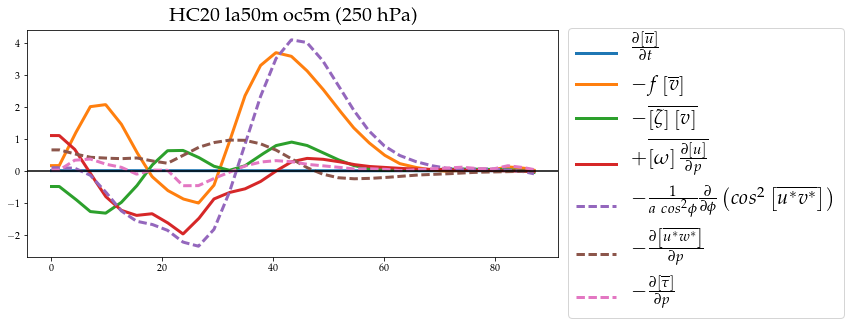

In [99]:
P=8
plot_annual_mean(expi=0, p= P)
plot_annual_mean(expi=1, p= P)
plot_annual_mean(expi=2, p= P)
plot_annual_mean(expi=3, p= P)

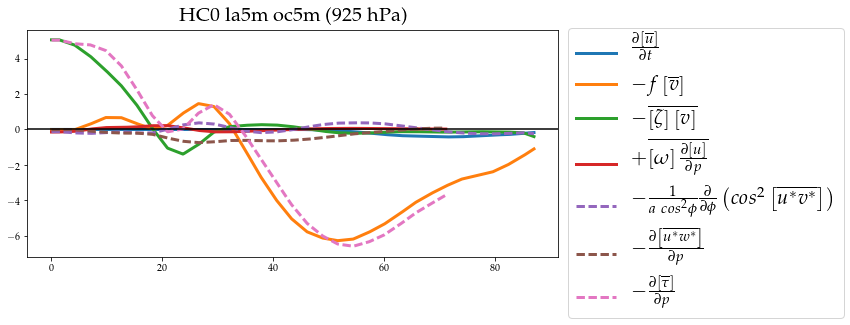

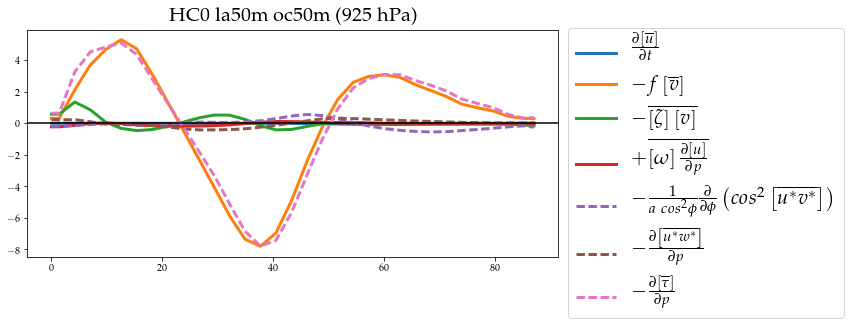

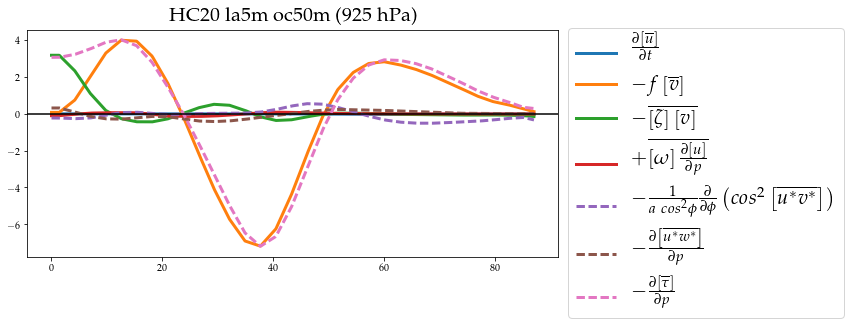

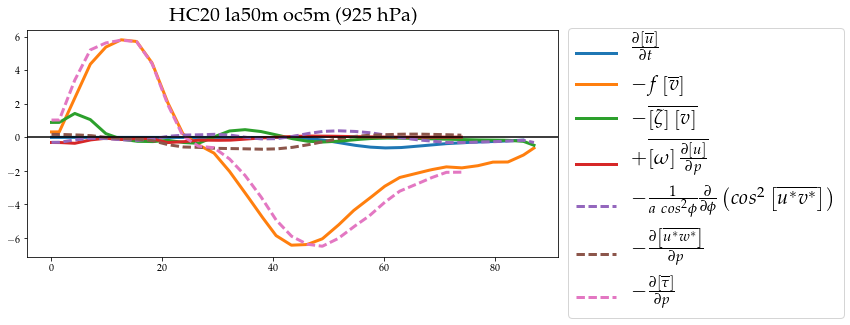

In [100]:
P=-4
plot_annual_mean(expi=0, p= P)
plot_annual_mean(expi=1, p= P)
plot_annual_mean(expi=2, p= P)
plot_annual_mean(expi=3, p= P)

In [101]:
def plot_each_month(expi=0, p= 8, m=0):
    fs =20
    py.figure(figsize=(8,4))
    py.plot(lat_a, lhs_term1[expi, :, p, m]*10**5, label=titles[0], lw=3); 
    py.plot(lat_a, lhs_term2[expi, :, p, m]*10**5, label=titles[1], lw=3); 
    py.plot(lat_a, lhs_term3[expi, :, p, m]*10**5, label=titles[2], lw=3);    
    py.plot(lat_a, lhs_term4[expi, :, p, m]*10**5, label=titles[3], lw=3);    

    py.plot(lat_a, rhs_term1[expi, :, p, m]*10**5, label=titles[4], lw=3, ls='--'); 
    py.plot(lat_a, rhs_term2[expi, :, p, m]*10**5, label=titles[5], lw=3, ls='--');
    
    py.plot(lat_a, stress_term[expi, :, p, m]*10**5, label=titles[6], lw=3, ls='--');
    py.title(exp_names[expi]+'  ('+str(int(pres[p]*100))+' hPa)', fontsize=fs, y=1.01)
    py.legend(loc='best',bbox_to_anchor=(1, 1.05), fontsize=20)
    py.axhline(0, color='k')
    py.tight_layout()
    

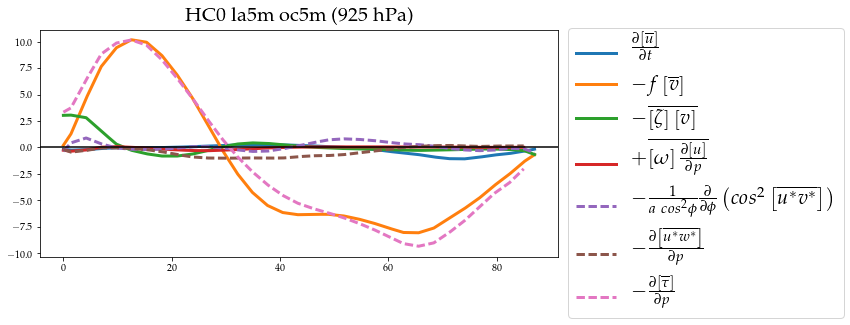

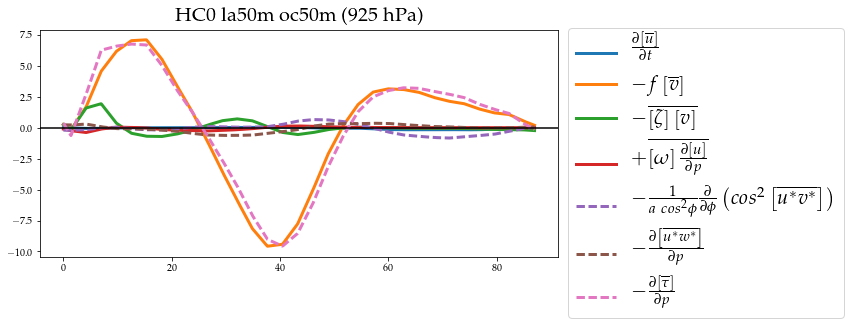

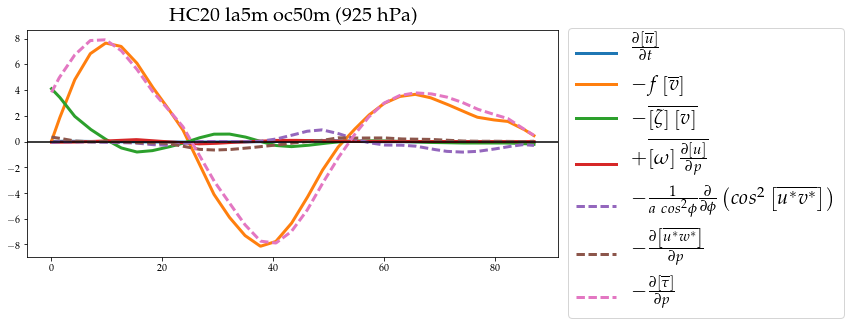

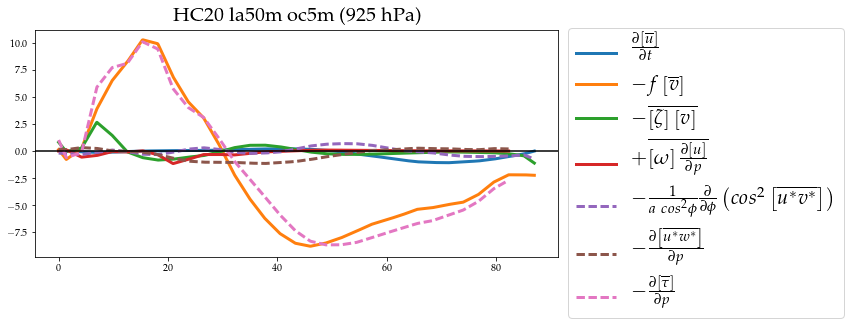

In [102]:
P=-4; M=0
plot_each_month(expi=0, p= P, m=M)
plot_each_month(expi=1, p= P, m=M)
plot_each_month(expi=2, p= P, m=M)
plot_each_month(expi=3, p= P, m=M)

In [103]:
# def plot_annual_mean1(expi=0, p= 8):
#     fs =20
#     py.figure(figsize=(8,4))
#     py.plot(lat_a, lhs_term3[expi, :, p, :-1].mean(axis=-1)*10**5,  label=titles[2], lw=3); 
#     py.plot(lat_a, lhs_term3a[expi, :, p, :-1].mean(axis=-1)*10**5, label='eddy',    lw=3); 
#     py.plot(lat_a, lhs_term3b[expi, :, p, :-1].mean(axis=-1)*10**5, label='mean',     lw=3);     
#     py.title(exp_names[expi]+'  ('+str(int(pres[p]*100))+' hPa)', fontsize=fs, y=1.01)
#     py.legend(loc='best',bbox_to_anchor=(1, 1.05), fontsize=20)
#     py.tight_layout()
    
# plot_annual_mean1(expi=0, p= 8)
# plot_annual_mean1(expi=1, p= 8)
# plot_annual_mean1(expi=2, p= 8)
# plot_annual_mean1(expi=3, p= 8)

In [104]:
print lhs_term1.shape
print pres*100

(4, 871, 27, 13)
[5.0000000e-01 1.0000000e+01 3.0000002e+01 5.0000000e+01 7.0000000e+01
 1.0000000e+02 1.5000000e+02 2.0000000e+02 2.5000000e+02 3.0000000e+02
 3.5000000e+02 4.0000000e+02 4.5000000e+02 5.0000000e+02 5.5000000e+02
 6.0000000e+02 6.5000000e+02 7.0000000e+02 7.5000000e+02 8.0000000e+02
 8.2500000e+02 8.5000000e+02 9.0000000e+02 9.2500000e+02 9.5000000e+02
 9.7500000e+02 1.0000000e+03]


In [105]:
months= ['J','F','M','A','J','J','A','S','O','N','D','J']

In [106]:
def plot_contours_vertical(expi=0, m= 0, max=8):
    fs =20
    py.figure(figsize=(15,15))
    ranges = np.arange(-max,max+2,2)
    py.subplot(4,3,1)
    py.contourf(lat_a, pres[1:]*100, (lhs_term1[expi, :, 1:, m]*10**5).T, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.gca().invert_yaxis()
    py.title(titles[0], fontsize=fs)
    py.subplot(4,3,2)
    py.contourf( lat_a, pres[1:]*100, (lhs_term2[expi, :, 1:, m]*10**5).T, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.gca().invert_yaxis()
    py.title(titles[1], fontsize=fs)
    py.subplot(4,3,3)
    py.contourf( lat_a, pres[1:]*100, (lhs_term3b[expi, :, 1:, m]*10**5).T, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.gca().invert_yaxis()
    py.title(titles[2], fontsize=fs)
    py.subplot(4,3,4)
    py.contourf(lat_a, pres[1:]*100, (lhs_term4b[expi, :, 1:, m]*10**5).T, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.gca().invert_yaxis()
    py.title(titles[3], fontsize=fs)

    py.subplot(4,3,5)
    py.contourf( lat_a, pres[1:]*100, (rhs_term1a[expi, :, 1:, m]*10**5).T, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.gca().invert_yaxis()
    py.title(titles[4], fontsize=fs)
    py.subplot(4,3,6)
    py.contourf(lat_a, pres[1:]*100,  (rhs_term2a[expi, :, 1:, m]*10**5).T, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.gca().invert_yaxis()
    py.title(titles[5], fontsize=fs)
    py.subplot(4,3,7)
    py.contourf(lat_a, pres[1:]*100,  (stress_term[expi, :, 1:, m]*10**5).T, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.gca().invert_yaxis()
    py.title(titles[6], fontsize=fs)

#     py.suptitle((months[m]), fontsize=fs, y=1.01)
    py.tight_layout()

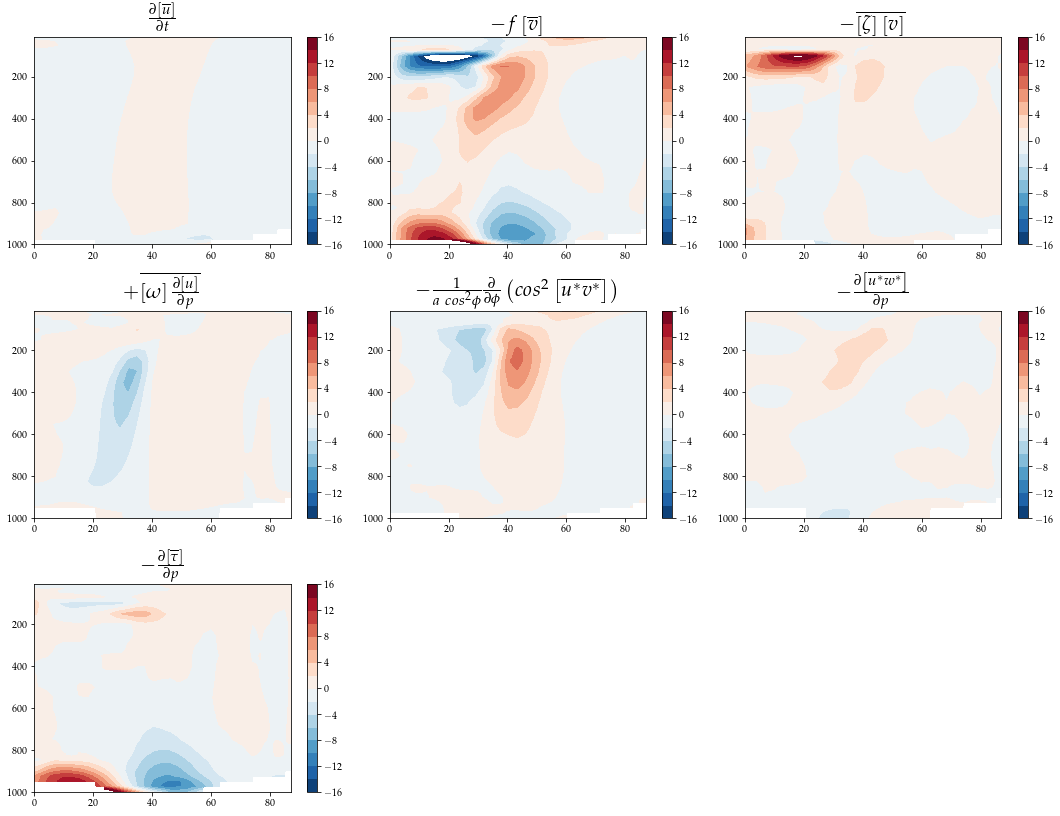

In [107]:
M=1
plot_contours_vertical(expi=0, m= M, max=16)

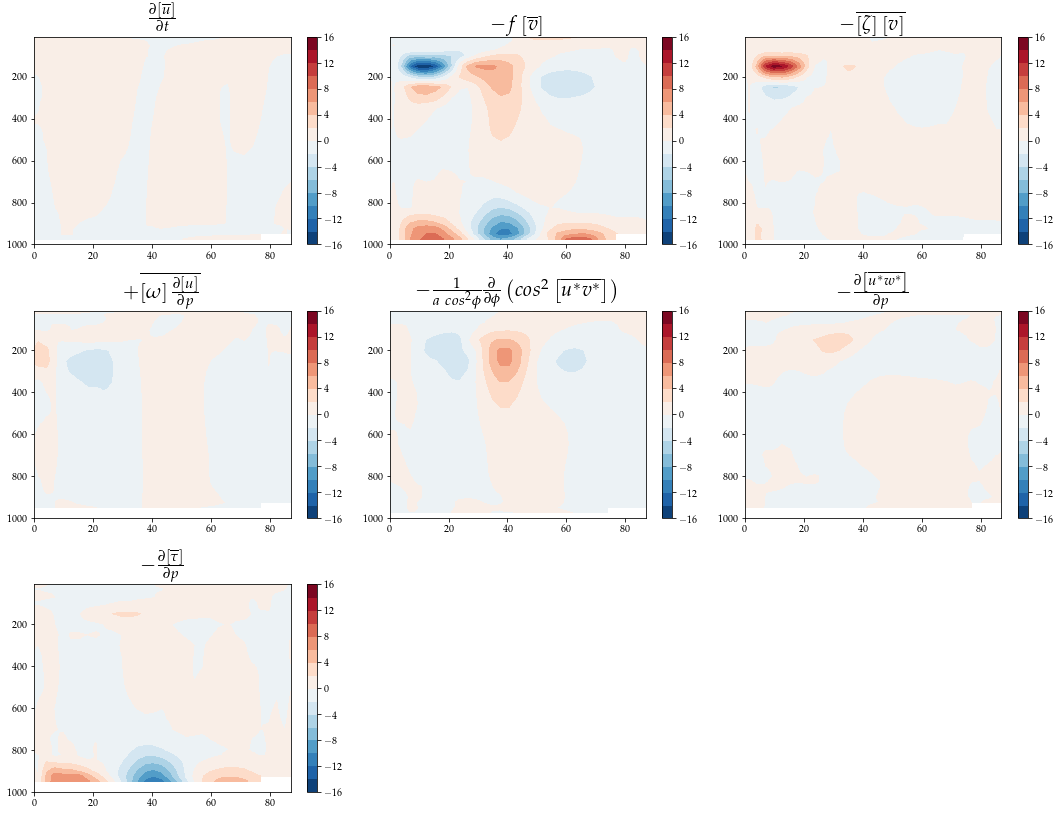

In [108]:
M=1
plot_contours_vertical(expi=1, m= M, max=16)

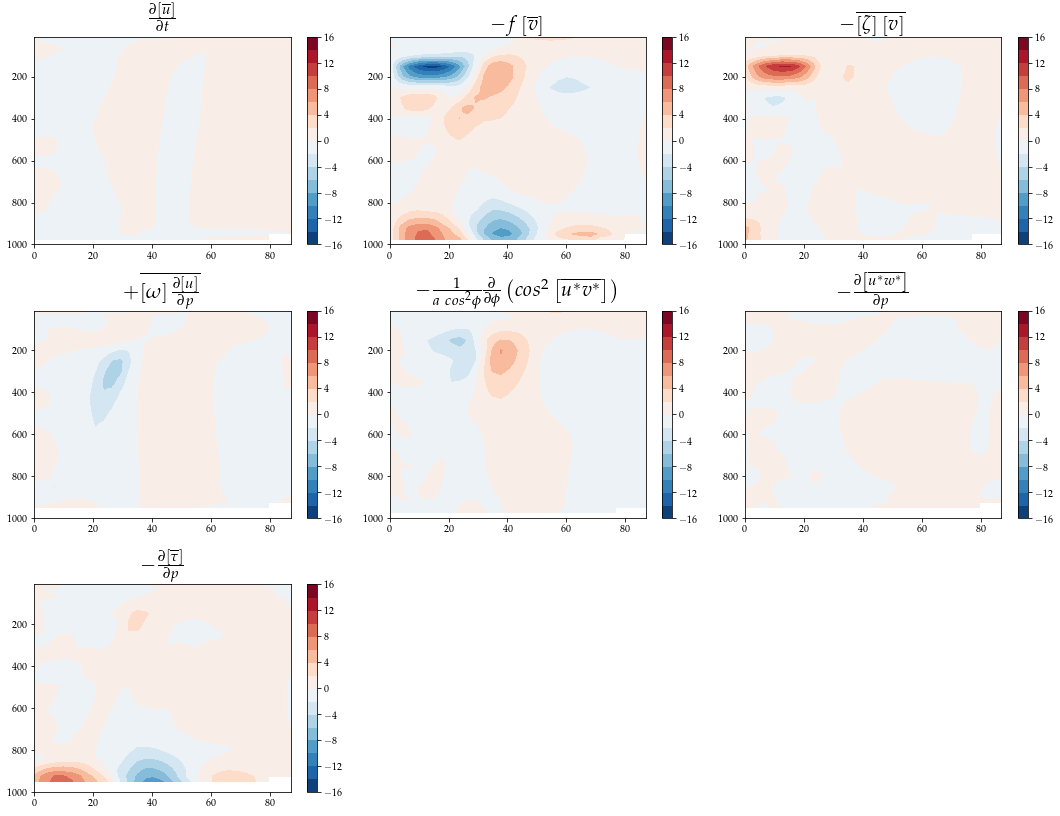

In [109]:
M=1
plot_contours_vertical(expi=2, m= M, max=16)

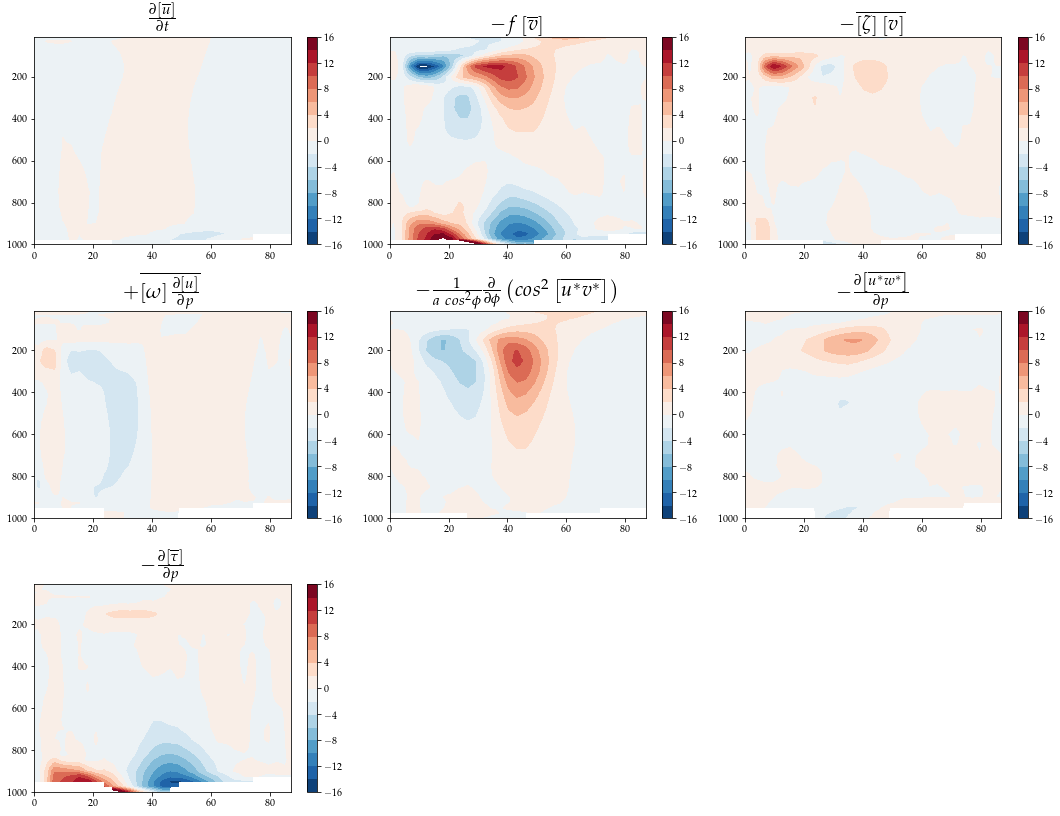

In [110]:
M=1
plot_contours_vertical(expi=3, m= M, max=16)

In [111]:
def plot_contours(expi=0, p= 8, max=8):
    MONTHS = lhs_term1.shape[-1]
    fs =20
    py.figure(figsize=(15,15))
    ranges = np.arange(-max,max+2,2)
    py.subplot(4,3,1)
    py.contourf(range(MONTHS), lat_a, lhs_term1[expi, :, p, :]*10**5, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.title(titles[0], fontsize=fs)
    py.subplot(4,3,2)
    py.contourf(range(MONTHS), lat_a, lhs_term2[expi, :, p, :]*10**5, ranges, cmap=cm.RdBu_r); py.colorbar()
#     py.contour(range(MONTHS), lat_a, (rhs_term1)[expi, :, p, :]*10**5, ranges, colors='k'); #py.colorbar()
    py.title(titles[1], fontsize=fs)
    py.subplot(4,3,3)
    py.contourf(range(MONTHS), lat_a, lhs_term3[expi, :, p, :]*10**5, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.title(titles[2], fontsize=fs)
    py.subplot(4,3,4)
    py.contourf(range(MONTHS), lat_a, lhs_term4[expi, :, p, :]*10**5, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.title(titles[3], fontsize=fs)

    py.subplot(4,3,5)
    py.contourf(range(MONTHS), lat_a, rhs_term1[expi, :, p, :]*10**5, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.title(titles[4], fontsize=fs)
    py.subplot(4,3,6)
    py.contourf(range(MONTHS), lat_a, rhs_term2[expi, :, p, :]*10**5, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.title(titles[5], fontsize=fs)
    py.subplot(4,3,7)
    py.contourf(range(MONTHS), lat_a, stress_term[expi, :, p, :]*10**5, ranges, cmap=cm.RdBu_r); py.colorbar()
    py.title(titles[6], fontsize=fs)
    py.suptitle(str(int(pres[p]*100))+' hPa', fontsize=fs, y=1.01)
    py.tight_layout()

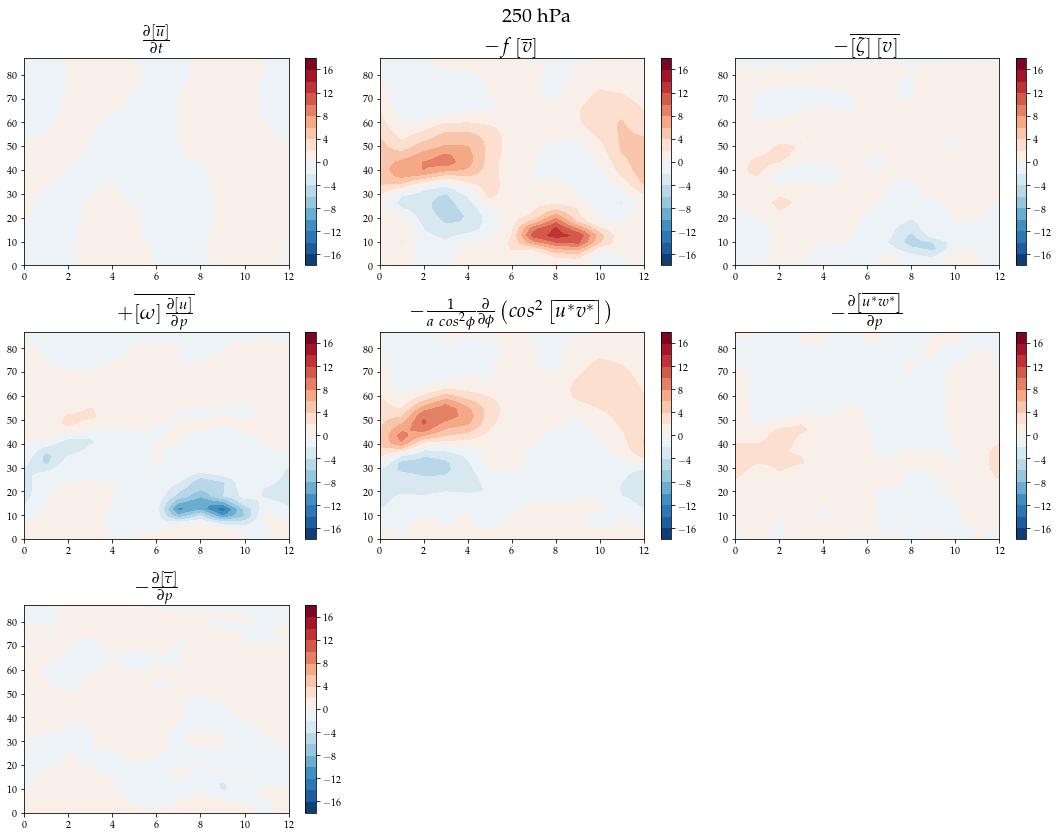

In [112]:
plot_contours(expi=0, p= 8, max=18)

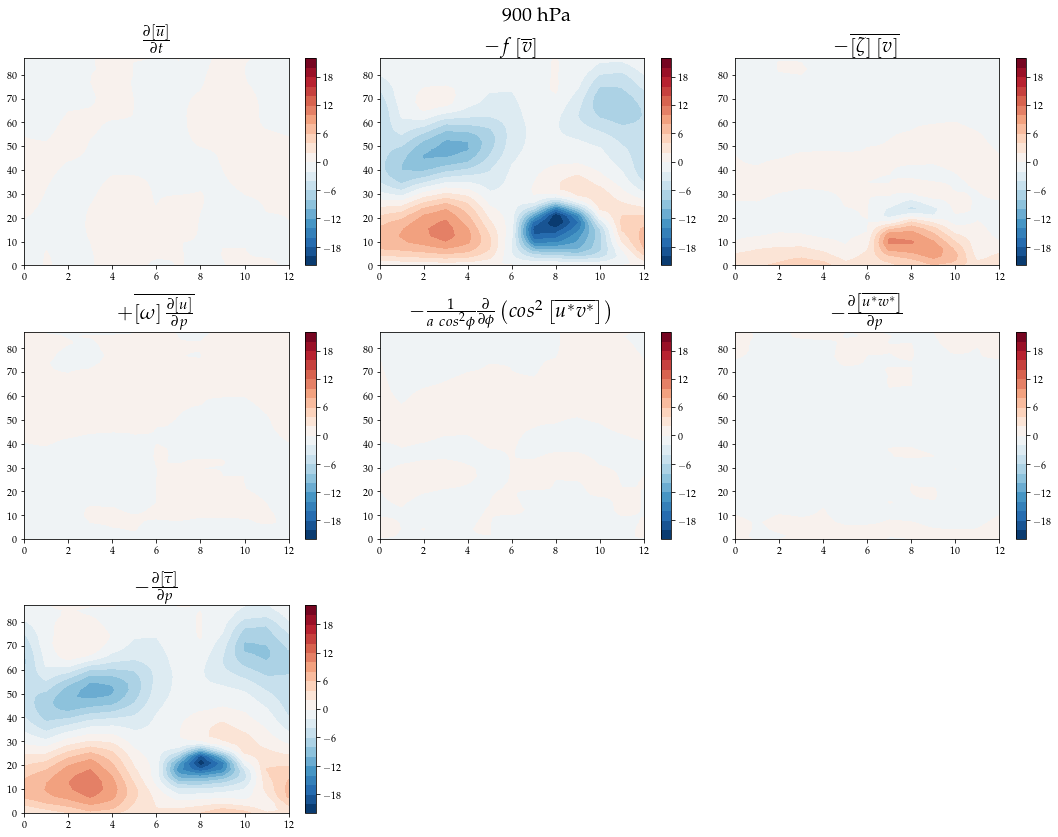

In [113]:
plot_contours(expi=0, p= -5, max=22)

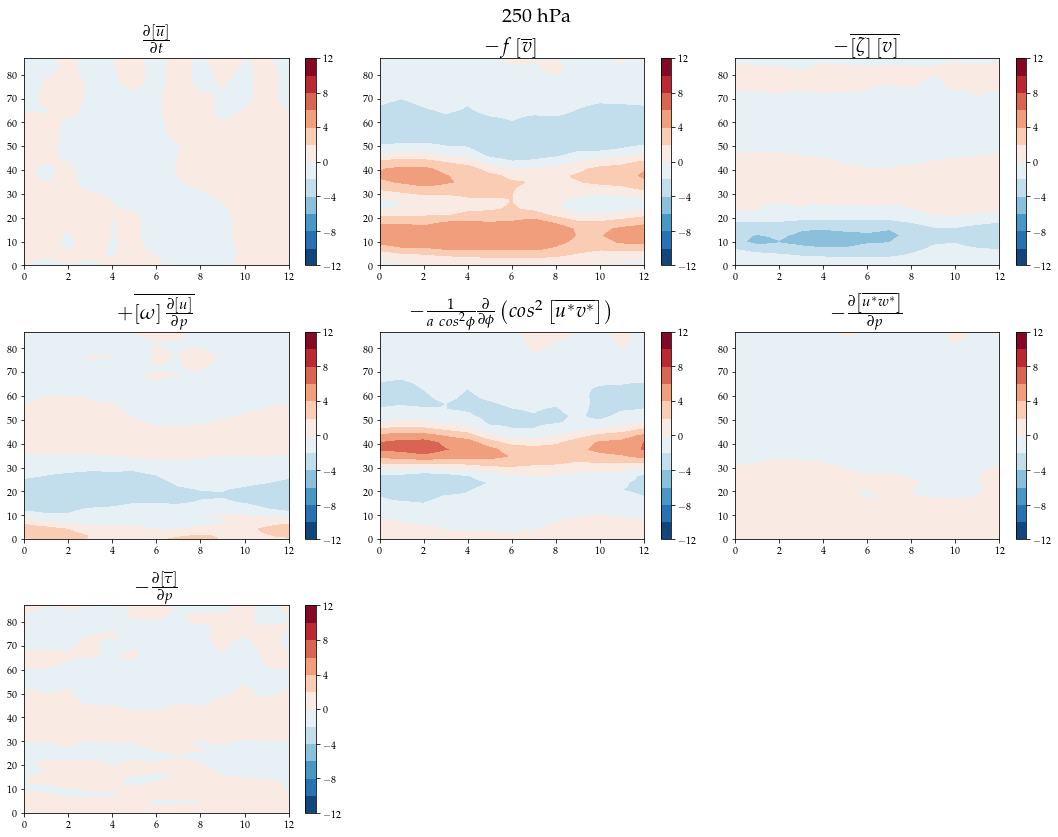

In [114]:
plot_contours(expi=1, p= 8, max=12)

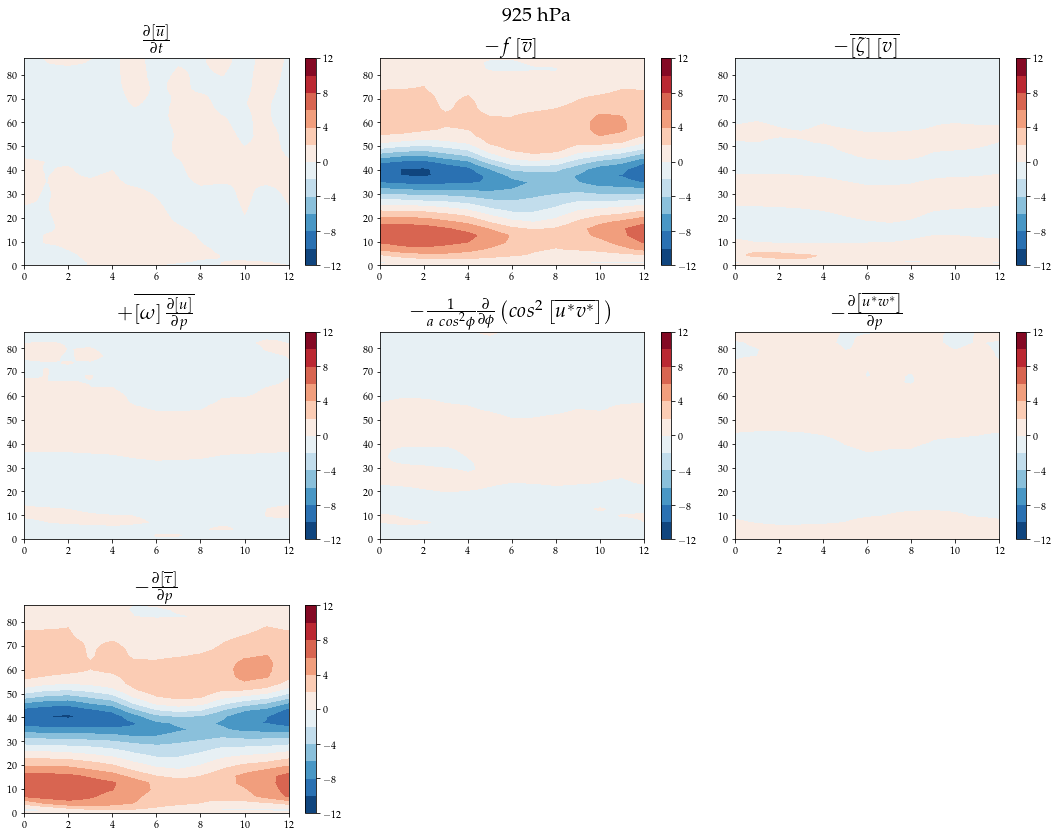

In [115]:
plot_contours(expi=1, p= -4, max=12)

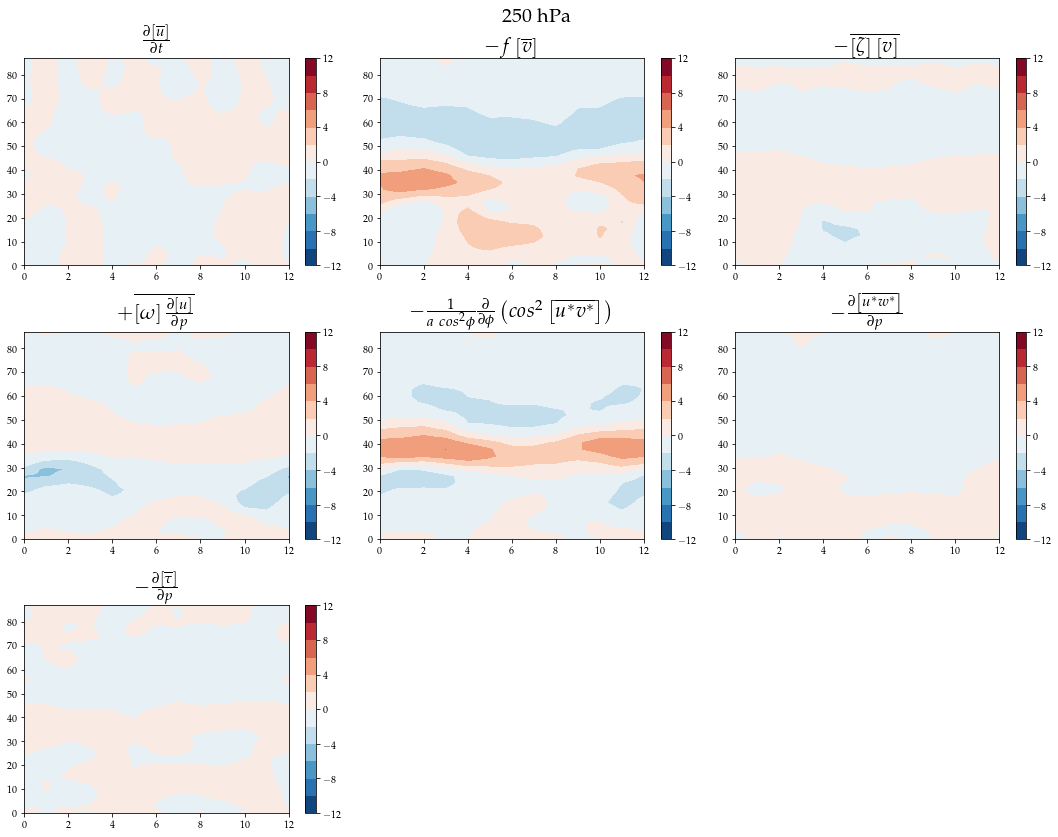

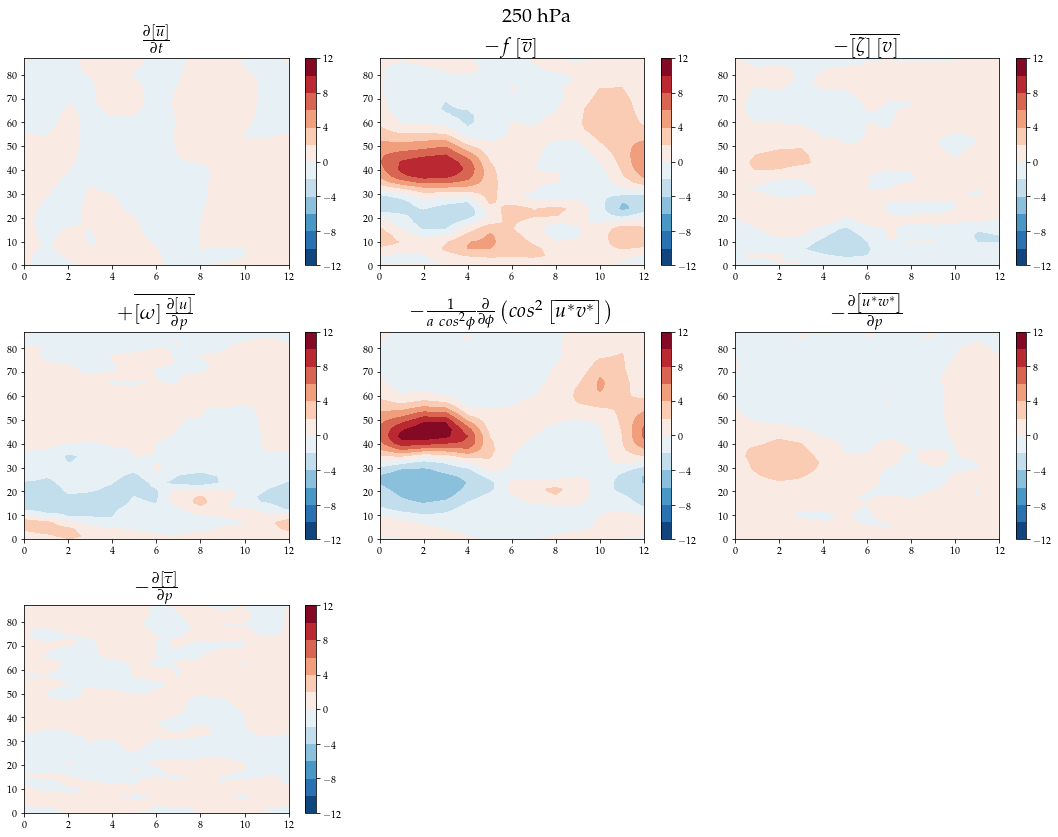

In [116]:
plot_contours(expi=2, p= 8, max=12)
plot_contours(expi=3, p= 8, max=12)

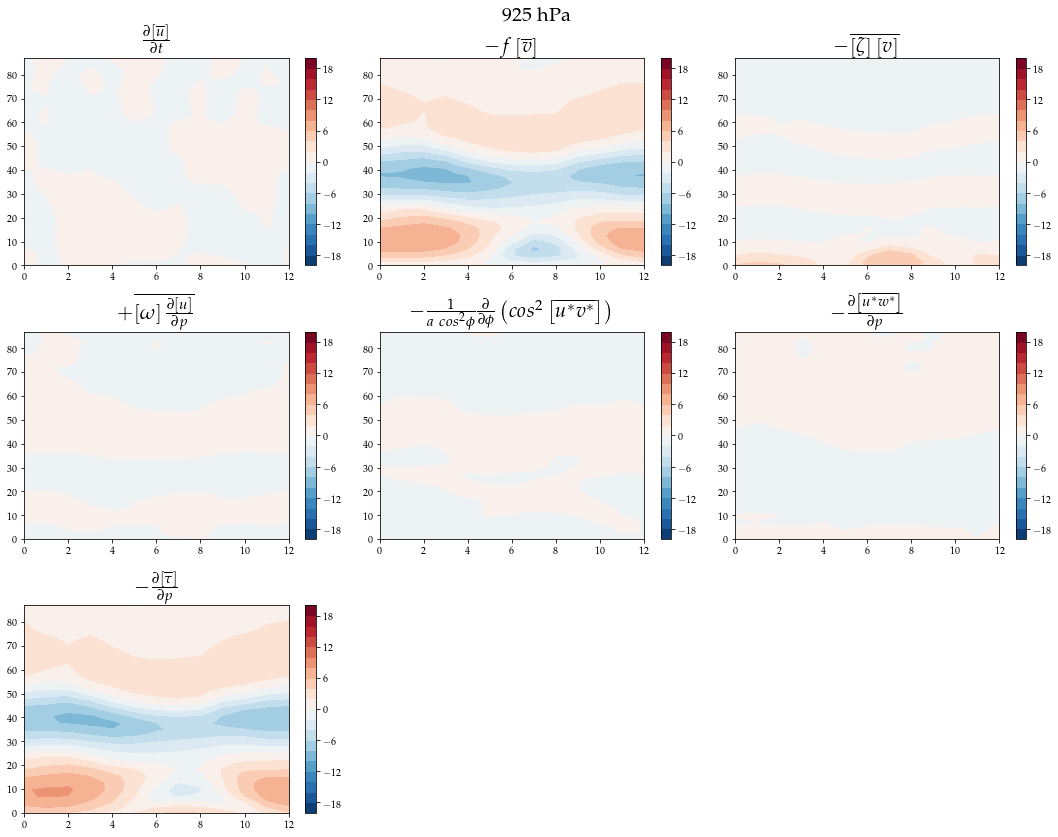

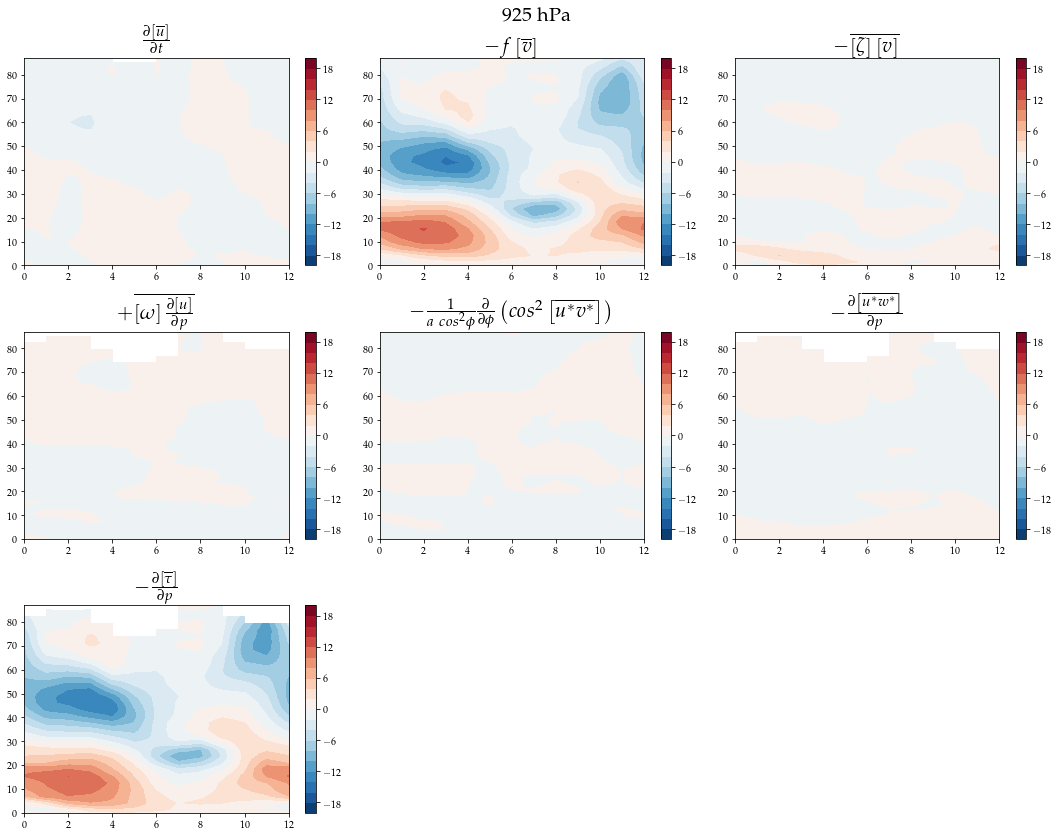

In [117]:
plot_contours(expi=2, p= -4, max=20)
plot_contours(expi=3, p= -4, max=20)